<a href="https://colab.research.google.com/github/jylin04/mi-ntk/blob/main/tms_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NTK <> TMS

In this notebook, I'll replicate some results from [TMS](https://transformer-circuits.pub/2022/toy_model/index.html) and [Superposition, Memorization and Double Descent](https://transformer-circuits.pub/2023/toy-double-descent/index.html), then study NTK-inspired hypotheses for feature learning in an instance of TMS where the empirical NTK is a good approximation.

# Setup (run this cell at start)


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import torch as t

from torch import nn, Tensor
from torch.nn import functional as F

from tqdm.notebook import tqdm

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

from matplotlib.colors import LinearSegmentedColormap

In [4]:
%pip install -q git+https://github.com/jylin04/mi-ntk.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
import tms, metrics, ntk

from tms import ReluModel
from tms import generate_batch, importance_weighted_loss, train_tms, generate_batch_with_norm, train_tms_fixed
from metrics import loss_acc_gap, r2_score
from ntk import full_jacobian, class_jacobian, empirical_ntk, LinearisedPredictor, eig_decompose, learn_dictionary_torch, learn_dictionary_supervised

In [6]:
# cfg
epochs: int = 5000
batch_size: int = 1024
lr: float = 1e-3
n_features: int = 80
n_hidden: int = 20
sparsity: float = 0.9
importance: float = 0.9

device = t.device("cuda" if t.cuda.is_available() else "cpu")
seed = 0

t.manual_seed(seed)

# 1. Replicate TMS baseline

Training loop.

In [ ]:
model = ReluModel(n_features=80, n_hidden=20).to(device)
optimizer = t.optim.Adam(model.parameters(), lr=lr)

In [ ]:
for step in tqdm(range(epochs)):
  train_loss = train_tms(model, optimizer, batch_size, n_features=80, S = 0.9, I = 0.9, device=device, loss_fn = importance_weighted_loss)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 0: Train loss 0.0030
Epoch 1000: Train loss 0.0003
Epoch 2000: Train loss 0.0002
Epoch 3000: Train loss 0.0002
Epoch 4000: Train loss 0.0002


Visualizing the results:

In [ ]:
def plot_weights(W, pytorch=True):
   ''' Do (1) for an individual weight matrix '''
   if pytorch:
    W = W.detach().cpu().numpy()
   plt.imshow(W.T @ W, vmin=-1.3, vmax=1.3, cmap="RdBu_r")

In [ ]:
def plot_norms(W, pytorch=True):
    ''' Do (2) for an individual weight matrix '''
    if pytorch:
      W = W.detach().cpu().numpy()

    n_hidden, n_features = W.shape                        # SHape is e.g. [5, 20]

    W_norm = W /(1e-5 + np.linalg.norm(W, axis=0))        # Shape is e.g. [5, 20], but each of the 20 vectors has been normalized in the [5] direction]

    superposition = np.zeros(n_features)
    for i in range(n_features):
      for j in range(n_features):
        if i != j:
          superposition[i] += (W_norm.T[i] @ W.T[j])**2

    colors = ["purple" if sup <=0.01 else "yellow" for sup in superposition]

    norms = np.linalg.norm(W, axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(2, 10))

    ax.barh(np.arange(len(norms)), norms, align='center', color=colors, alpha=0.8)
    ax.set_yticks([])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xticks([])

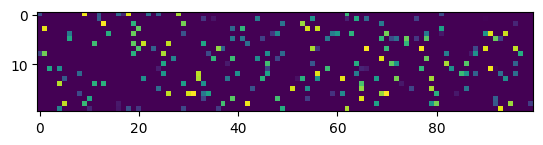

In [ ]:
# Visualize the dataset
plt.imshow(generate_batch(100, 20, 0.9).T)
plt.show();

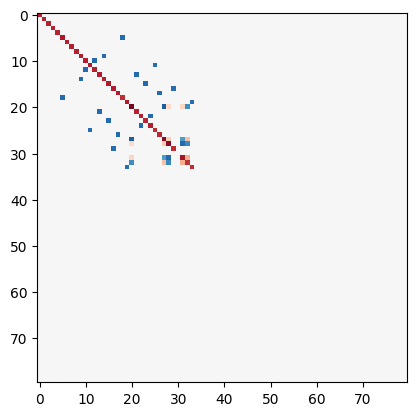

In [ ]:
plot_weights(model.W)

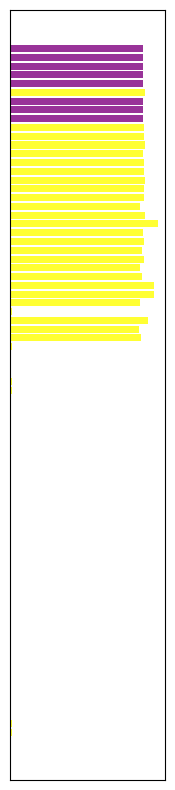

In [ ]:
plot_norms(model.W)

# 2. Replicate "Superposition, Memorization & Double Descent"

Next, we'd like to redo the TMS experiment with a fixed, normalized dataset.

In [ ]:
# cfg

batch_size: int = 100
n_features: int = 10   # <- replicates the plots in Marius Hobbhahn's LW post
n_hidden: int = 5
sparsity: float = 0.9
importance: float = 0.8

epochs = 2001

Training loop.

In [ ]:
# Use one fixed dataset for all epochs
dataset = generate_batch_with_norm(batch_size, n_features, sparsity).to(device)
model = ReluModel(n_features, n_hidden).to(device)
optimizer = t.optim.Adam(model.parameters(), lr = lr)

In [ ]:
for step in tqdm(range(epochs)):
  train_loss = train_tms_fixed(model, dataset, optimizer, importance)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

  0%|          | 0/2001 [00:00<?, ?it/s]

Epoch 0: Train loss 0.0166
Epoch 1000: Train loss 0.0004
Epoch 2000: Train loss 0.0002


Plots of the trained parameters.

(What exactly are we plotting here?:

- In "features": the 1000 vectors that map each of 1000 1-hot-encoded input vectors (features) to the hidden space.

- In "hidden vectors": the representation of each of the 1000 entries of the fixed dataset in the hidden space.)

In [ ]:
W = model.W.detach().cpu().numpy()
hidden_vectors = W @ dataset.T.detach().cpu().numpy()

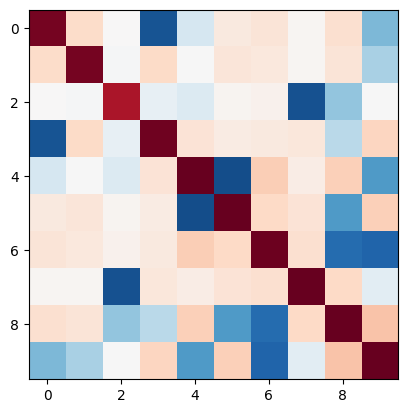

In [ ]:
plot_weights(W, False)

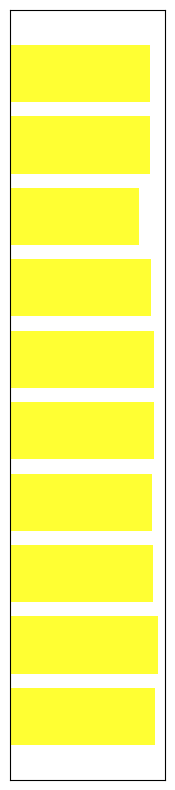

In [ ]:
plot_norms(W, False)

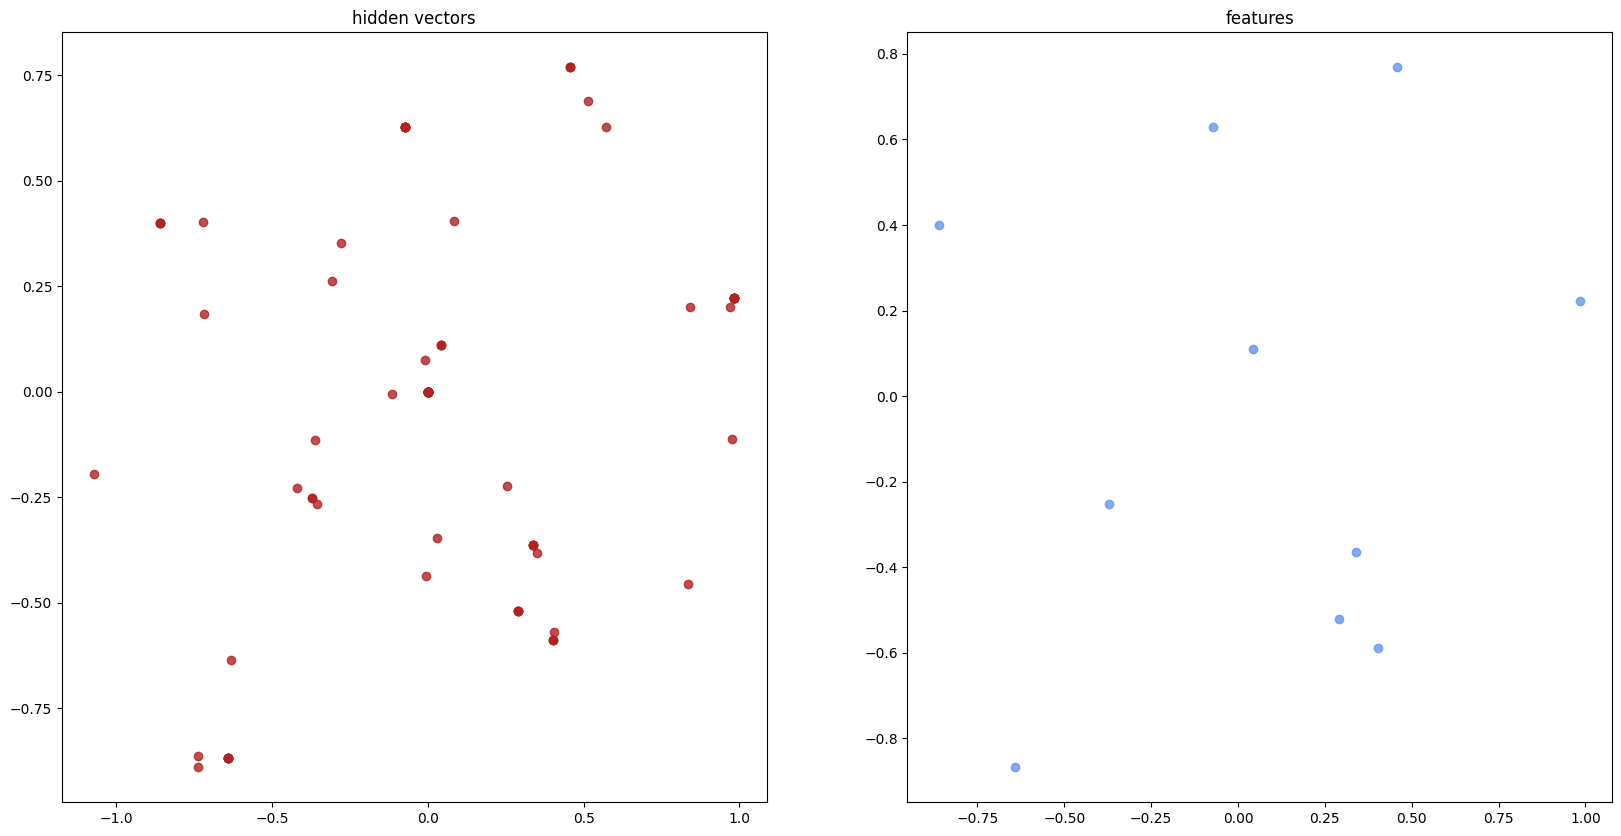

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].scatter(hidden_vectors[0], hidden_vectors[1], color="firebrick", alpha=0.8)
ax[0].set_title("hidden vectors")

ax[1].scatter(W[0], W[1], color="cornflowerblue", alpha=0.8)
ax[1].set_title("features")

plt.show();

Double descent curve when sweeping over different dataset sizes.

In [ ]:
data_sizes = [3, 5, 8, 10, 15, 30, 50, 100, 200, 500, 1000] #, 2000] #, 5000, 10000, 20000]

n_features: int = 50
n_hidden: int = 10
sparsity: float = 0.3
importance: float = 0.8

epochs: int = 3001

In [ ]:
train_sets = []
test_sets = []
train_losses = []
test_losses = []
weights = []

In [ ]:
for i in tqdm(range(len(data_sizes))):

  dataset_size = data_sizes[i]

  model = ReluModel(n_features, n_hidden).to(device)
  dataset = generate_batch_with_norm(dataset_size, n_features, sparsity).to(device)
  optimizer = t.optim.Adam(model.parameters(), lr = lr)

  for step in range(epochs):
    train_loss = train_tms_fixed(model, dataset, optimizer, importance)
#    if (step % 1000 == 0):
#      print(f"Epoch {step}: Train loss {train_loss:.4f}")

  test_set = generate_batch_with_norm(dataset_size, n_features, sparsity).to(device)

  train_losses.append(train_loss.item())
  test_losses.append(importance_weighted_loss(test_set, model(test_set), t.tensor(importance, device=test_set.device)**t.arange(n_features, device = test_set.device)).item()*1000)
  train_sets.append(dataset.detach().cpu().numpy())
  test_sets.append(test_set.detach().cpu().numpy())
  weights.append(model.W.detach().cpu().numpy())

  0%|          | 0/11 [00:00<?, ?it/s]

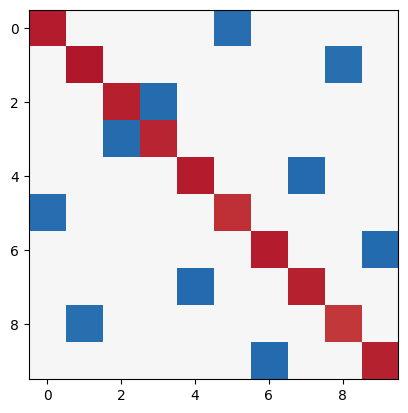

In [ ]:
plot_weights(weights[10], False)

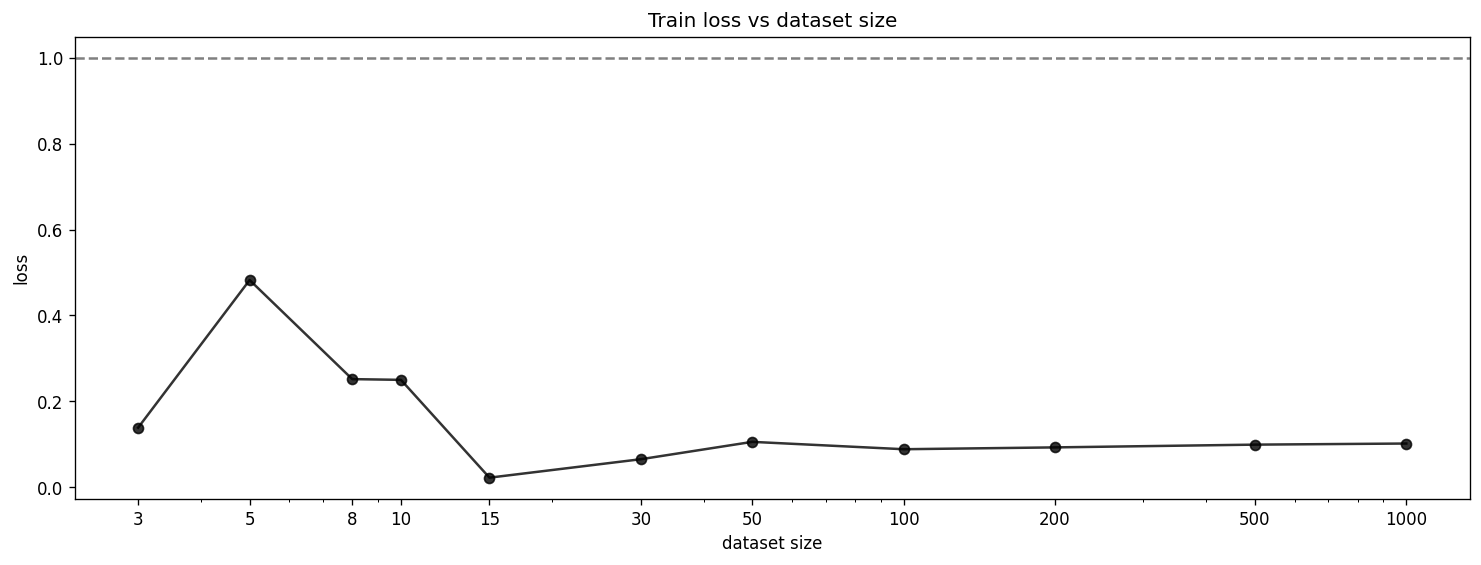

In [ ]:
scalar = 1000
train_losses_scaled = [a*scalar for a in train_losses]

fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=120)

ax.axhline(1, linestyle="--", color="grey")
ax.set_ylabel("loss")
ax.set_xlabel("dataset size")
ax.plot(data_sizes, train_losses_scaled, '-o', color="black", alpha=0.8)
ax.set_xscale("log")
ax.set_title("Train loss vs dataset size")

ax.set_xticks(data_sizes)
ax.set_xticklabels(data_sizes)

plt.show();

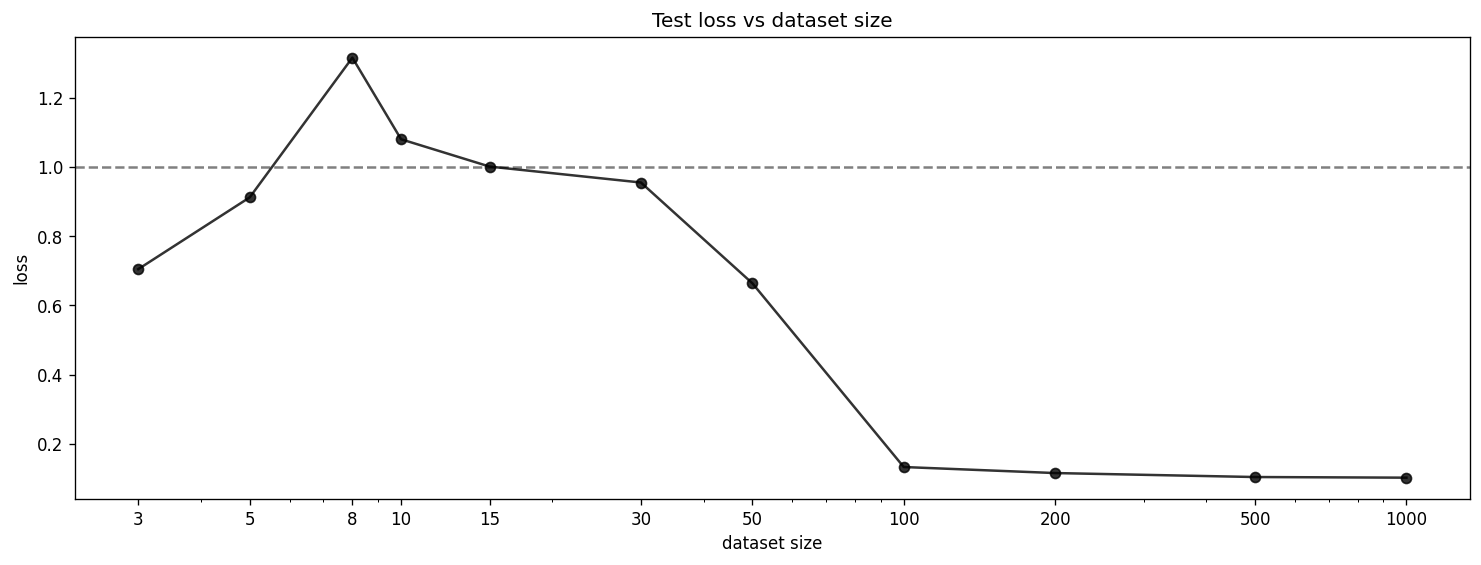

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=120)

ax.axhline(1, linestyle="--", color="grey")
ax.set_ylabel("loss")
ax.set_xlabel("dataset size")
ax.plot(data_sizes, test_losses, '-o', color="black", alpha=0.8)
ax.set_xscale("log")
ax.set_title("Test loss vs dataset size")

ax.set_xticks(data_sizes)
ax.set_xticklabels(data_sizes)

plt.show();

Using Marius Hobbhahn's code to visualize the features and training set hidden vectors:

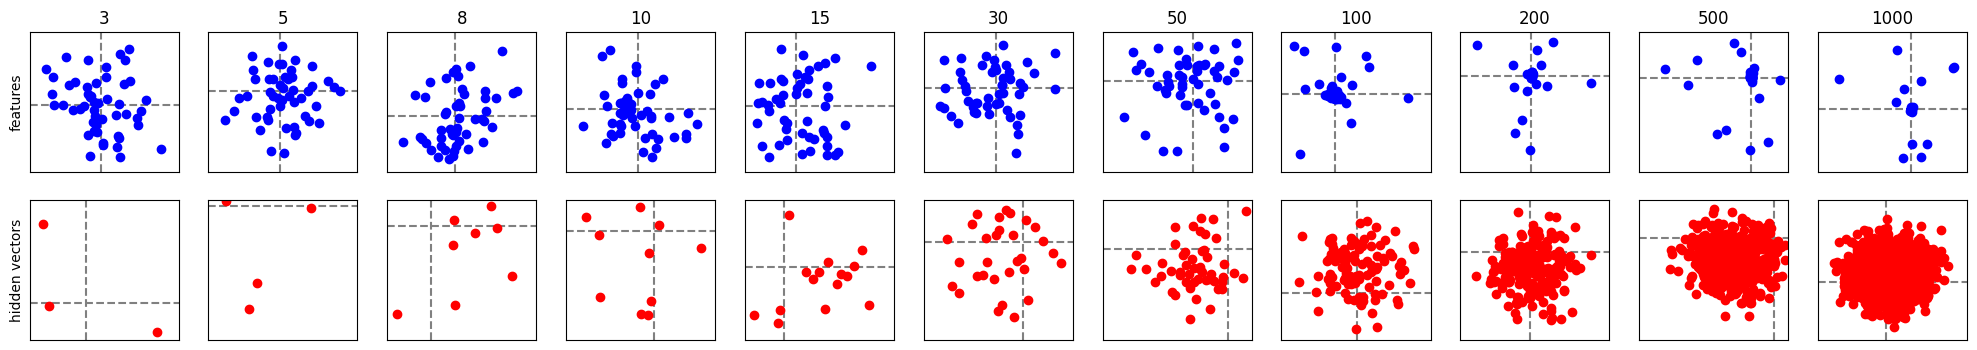

In [ ]:
#### visualize features

## think about centering each plot at 0

fig, ax = plt.subplots(2, len(data_sizes), figsize=(25, 4))
c = 1.3

ax[0][0].set_ylabel("features")
ax[1][0].set_ylabel("hidden vectors")

hidden_vectors_list = []

for i in range(len(data_sizes)):

    W = weights[i]
    inputs = train_sets[i]
    s = data_sizes[i]

    hidden_vectors = W @ inputs.T
    hidden_vectors_list.append(hidden_vectors)

    ax[0][i].scatter(W[0], W[1], color="blue", alpha=1)
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
    ax[0][i].set_xlim(c*W[0].min().item(), c*W[0].max().item())
    ax[0][i].set_ylim(c*W[1].min().item(), c*W[1].max().item())
    ax[0][i].set_title(str(s))
    ax[0][i].axvline(0, linestyle="--", color="grey", zorder=-1)
    ax[0][i].axhline(0, linestyle="--", color="grey", zorder=-1)

    ax[1][i].scatter(hidden_vectors[0], hidden_vectors[1], color="red", alpha=1)
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])
    ax[1][i].set_xlim(c*hidden_vectors[0].min().item(), c*hidden_vectors[0].max().item())
    ax[1][i].set_ylim(c*hidden_vectors[1].min().item(), c*hidden_vectors[1].max().item())
    ax[1][i].axvline(0, linestyle="--", color="grey", zorder=-1)
    ax[1][i].axhline(0, linestyle="--", color="grey", zorder=-1)

plt.show();

# 3. Check if linearized approximation at the end of training is a good approximation

Let's check that the empirical NTK with MSE loss is a good approximation for a few models that we can then try to interpret. Note that we shouldn't expect this to give a good result for other loss functions.

(Since we only need one or two specific models to work with *and* for a given choice of (m,n) we have to manually check that (S, I) gives a reasonable double descent curve, let's check select models one at a time until we have one or two that work, rather than doing a hyperparameter sweep.)

### Choice 1: D=100, n=10, m = 5, S = 0.9, I = 0.8

In [ ]:
batch_size: int = 100
n_features: int = 10
n_hidden: int = 5
sparsity: float = 0.9
importance: float = 0.8

epochs = 5000

dataset = generate_batch_with_norm(batch_size, n_features, sparsity).to(device)
model = ReluModel(n_features, n_hidden).to(device)
optimizer = t.optim.Adam(model.parameters(), lr = lr)

for step in tqdm(range(epochs)):
  train_loss = train_tms_fixed(model, dataset, optimizer, importance, loss_fn = importance_weighted_loss)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 0: Train loss 0.0201
Epoch 1000: Train loss 0.0002
Epoch 2000: Train loss 0.0001
Epoch 3000: Train loss 0.0001
Epoch 4000: Train loss 0.0001


In [ ]:
linearized_model = LinearisedPredictor(model, dataset, dataset, ridge = 5e-4)
(loss_acc_gap(model, linearized_model, dataset, dataset, expand_around_model=True), r2_score(model, linearized_model, dataset, expand_around_model=True))

((0.5673905916980617, 0.0), tensor(0.9938, device='cuda:0'))

In [ ]:
(loss_acc_gap(model, linearized_model, dataset, dataset, expand_around_model=False), r2_score(model, linearized_model, dataset, expand_around_model=False))

((0.8470933356554851, 0.0), tensor(0.9996, device='cuda:0'))

ChatGPT (o3) suggests cutoffs of <=1.10 loss ratio (acceptable: 1.1-1.3), <= 2pp accuracy gain (acceptable: 2pp-5pp) and R2 score >=0.8.

These hyperparameters put us squarely in this range. In fact, the eNTK approximation does better than the real model.

The eNTK approximation does about equally well in the pure NTK and when we linearize around the trained model.

#### Sanity check that it's stable to a larger dataset: D=1000, n=10, m = 5, S = 0.9, I = 0.8

In [ ]:
batch_size: int = 1000
n_features: int = 10
n_hidden: int = 5
sparsity: float = 0.9
importance: float = 0.8

epochs = 5000

dataset = generate_batch_with_norm(batch_size, n_features, sparsity).to(device)
model = ReluModel(n_features, n_hidden).to(device)
optimizer = t.optim.Adam(model.parameters(), lr = lr)

for step in tqdm(range(epochs)):
  train_loss = train_tms_fixed(model, dataset, optimizer, importance)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 0: Train loss 0.0216
Epoch 1000: Train loss 0.0019
Epoch 2000: Train loss 0.0010
Epoch 3000: Train loss 0.0008
Epoch 4000: Train loss 0.0008


Now at ridge parameter 1e-5, the result is numerically unstable, possibly because the larger dataset size -> smaller NTK eigenvalues on the tail. But at the ~smallest ridge parameter OOM where the metrics aren't terrible, they seem reasonable.

Note that if we keep cranking *up* the ridge parameter we get good metrics but are probably killing off all the fine-grained structure.

In [ ]:
linearized_model = LinearisedPredictor(model, dataset, dataset, ridge = 1e-4)
(loss_acc_gap(model, linearized_model, dataset, dataset, expand_around_model=True), r2_score(model, linearized_model, dataset, expand_around_model=True))

((1.0375585512812697, 0.4999995231628418), tensor(0.9976, device='cuda:0'))

In [ ]:
(loss_acc_gap(model, linearized_model, dataset, dataset, expand_around_model=False), r2_score(model, linearized_model, dataset, expand_around_model=False))

((1.1662084054387363, 0.40000081062316895), tensor(0.9937))

In [ ]:
linearized_model = LinearisedPredictor(model, dataset, dataset, ridge = 1)
(loss_acc_gap(model, linearized_model, dataset, dataset, expand_around_model=True), r2_score(model, linearized_model, dataset, expand_around_model=True))

((0.9919644397523286, -0.09999871253967285), tensor(0.9997))

### Choice 2 [if we want more features]: D=500, n=50, m = {5 or 10}, S = 0.9, I = 0.8

In [ ]:
batch_size: int = 500
n_features: int = 50
n_hidden: int = 5
sparsity: float = 0.9
importance: float = 0.8

epochs = 5001

dataset = generate_batch_with_norm(batch_size, n_features, sparsity).to(device)
model = ReluModel(n_features, n_hidden).to(device)
optimizer = t.optim.Adam(model.parameters(), lr = lr)

for step in tqdm(range(epochs)):
  train_loss = train_tms_fixed(model, dataset, optimizer, importance)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

  0%|          | 0/5001 [00:00<?, ?it/s]

Epoch 0: Train loss 0.0016
Epoch 1000: Train loss 0.0002
Epoch 2000: Train loss 0.0002
Epoch 3000: Train loss 0.0002
Epoch 4000: Train loss 0.0002
Epoch 5000: Train loss 0.0002


In [ ]:
linearized_model = LinearisedPredictor(model, dataset, dataset, ridge = 1e-4)
(loss_acc_gap(model, linearized_model, dataset, dataset, expand_around_model=True), r2_score(model, linearized_model, dataset, expand_around_model=True))

((0.9387118876026626, -1.4000006020069122), tensor(0.5760, device='cuda:0'))

In [ ]:
(loss_acc_gap(model, linearized_model, dataset, dataset, expand_around_model=False), r2_score(model, linearized_model, dataset, expand_around_model=False))

((0.9987342335383874, 2.400001883506775), tensor(0.9303, device='cuda:0'))

From ridge=1e-5 to 1e-4, the R^2 increases monotonically from very negative to what we see here.

In [ ]:
batch_size: int = 500
n_features: int = 50
n_hidden: int = 10
sparsity: float = 0.9
importance: float = 0.8

epochs = 5001

dataset = generate_batch_with_norm(batch_size, n_features, sparsity).to(device)
model = ReluModel(n_features, n_hidden).to(device)
optimizer = t.optim.Adam(model.parameters(), lr = lr)

for step in tqdm(range(epochs)):
  train_loss = train_tms_fixed(model, dataset, optimizer, importance)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

  0%|          | 0/5001 [00:00<?, ?it/s]

Epoch 0: Train loss 0.0015
Epoch 1000: Train loss 0.0001
Epoch 2000: Train loss 0.0000
Epoch 3000: Train loss 0.0000
Epoch 4000: Train loss 0.0000
Epoch 5000: Train loss 0.0000


In [ ]:
linearized_model = LinearisedPredictor(model, dataset, dataset, ridge = 1e-4)
(loss_acc_gap(model, linearized_model, dataset, dataset, expand_around_model=True), r2_score(model, linearized_model, dataset, expand_around_model=True))

((0.9879742478843584, 1.2000024318695068), tensor(0.9587, device='cuda:0'))

In [ ]:
(loss_acc_gap(model, linearized_model, dataset, dataset, expand_around_model=False), r2_score(model, linearized_model, dataset, expand_around_model=False))

((0.9881908439223093, 1.3999998569488525), tensor(0.9594, device='cuda:0'))

# 4. Check alignment of the top eNTK eigenvectors with the ground-truth features

## Flattened NTK results (incl. plots for the paper)

In [1]:
'''# 1-of function for TMS

from functorch import make_functional, jacrev, vmap
from typing import Tuple

def empirical_ntk_rescaled_by_importance(model: nn.Module, I: float, x_1: t.Tensor, x_2: t.Tensor) -> t.Tensor:
    """
    Returns a *rescaled* NTK(x_1, x_2), of shape (N_1, N_2, C_1, C_2)
    where N_1 = len(x_1), N_2= len(x_2) and C_* are the output dims:

    Namely, we rescale the axis of the Jacobian corresponding to class by sqrt(importance) of each class
    before computing the eNTK with it.
    """
    N, C = x_1.shape

    model = model.eval()
    fmodel, params = make_functional(model)

    # Function that runs a single example
    def fnet_single(params: Tuple[t.Tensor, ...], x: t.Tensor) -> t.Tensor:
        return fmodel(params, x.unsqueeze(0)).squeeze(0)

    # Jacobians. jacrev returns a per-sample function jac_fn(params, x) -> Tuple[T.Tensor, ...]. vmap vectorizes it letting us loop over the batch.
    jac1 = vmap(jacrev(fnet_single), (None, 0))(
        params, x_1
    )  # Tuple[t.Tensor...] with one entry per parameter of size *S_i, where jac[i] has shape(N_1, C_1, *S_i).
    jac2 = vmap(jacrev(fnet_single), (None, 0))(params, x_2)

    jac1 = [
        j.flatten(start_dim=2) for j in jac1
    ]  # Concat params into one axis. jac[i] has shape [N_1, C, P_i]
    jac2 = [j.flatten(start_dim=2) for j in jac2]

    # Rescale each class axis by the importance of the class.
    #imp = t.tensor(I, device = x_1.device)**t.arange(C, device = x_1.device).sqrt()
    imp = t.tensor(I, device = x_1.device)**(t.arange(C, device = x_1.device)/2)
    jac1 = [t.einsum("Ncp,c->Ncp", j, imp) for j in jac1]
    jac2 = [t.einsum("Ncp,c->Ncp", j, imp) for j in jac2]

    out = t.stack(
        [t.einsum("Ncp,Mdp->NMcd", j1, j2) for j1, j2 in zip(jac1, jac2)]
    )  # Contract over P in each NTK block
    out = out.sum(0)
    return out'''

'# 1-of function for TMS\n\nfrom functorch import make_functional, jacrev, vmap\nfrom typing import Tuple\n\ndef empirical_ntk_rescaled_by_importance(model: nn.Module, I: float, x_1: t.Tensor, x_2: t.Tensor) -> t.Tensor:\n    """\n    Returns a *rescaled* NTK(x_1, x_2), of shape (N_1, N_2, C_1, C_2)\n    where N_1 = len(x_1), N_2= len(x_2) and C_* are the output dims:\n\n    Namely, we rescale the axis of the Jacobian corresponding to class by sqrt(importance) of each class\n    before computing the eNTK with it.\n    """\n    N, C = x_1.shape\n\n    model = model.eval()\n    fmodel, params = make_functional(model)\n\n    # Function that runs a single example\n    def fnet_single(params: Tuple[t.Tensor, ...], x: t.Tensor) -> t.Tensor:\n        return fmodel(params, x.unsqueeze(0)).squeeze(0)\n\n    # Jacobians. jacrev returns a per-sample function jac_fn(params, x) -> Tuple[T.Tensor, ...]. vmap vectorizes it letting us loop over the batch.\n    jac1 = vmap(jacrev(fnet_single), (None, 0

In [ ]:
from functorch import make_functional, jacrev, vmap
from typing import Tuple


def empirical_ntk_rescaled_by_importance(
    model: nn.Module,
    I,                     # float or 1D tensor of shape [C]
    x_1: t.Tensor, x_2: t.Tensor,
    tau: float = 1.0       # tau=1 => principled D^{1/2}; tau=0 => no rescaling
) -> t.Tensor:
    """
    Returns K_D^tau(x1,x2) = D^{tau/2} J(x1) J(x2)^T D^{tau/2},
    where D = diag(I_vec). tau lets you 'soften' the importance (robustness sweep).
    """
    model = model.eval()
    fmodel, params = make_functional(model)

    def fnet_single(p, x): return fmodel(p, x.unsqueeze(0)).squeeze(0)

    jac1 = vmap(jacrev(fnet_single), (None, 0))(params, x_1)
    jac2 = vmap(jacrev(fnet_single), (None, 0))(params, x_2)
    jac1 = [j.flatten(start_dim=2) for j in jac1]   # [N, C, P_i]
    jac2 = [j.flatten(start_dim=2) for j in jac2]

    N, C = x_1.shape

    # Build per-class weights I_vec
    if t.is_tensor(I):
        I_vec = I.to(x_1.device).reshape(C)
    else:
        I_vec = t.pow(t.as_tensor(I, device=x_1.device), t.arange(C, device=x_1.device))

    # Correct importance factor is D^{1/2}. We allow D^{tau/2} to soften/harden.
    imp = t.pow(I_vec, tau / 2.0)  # tau=1 → sqrt(I_vec)

    jac1 = [t.einsum("ncp,c->ncp", j, imp) for j in jac1]
    jac2 = [t.einsum("ncp,c->ncp", j, imp) for j in jac2]

    blocks = [t.einsum("ncp,mdp->nmcd", j1, j2) for j1, j2 in zip(jac1, jac2)]
    return t.stack(blocks, dim=0).sum(0)  # [N, M, C, D]

In [ ]:
def eig_flat_plot_rescaled(model: nn.Module, dataset: t.Tensor, title: str, exp_param: int = 4, normalize: bool = True) -> None:
  """
  Plot the eigenspectrum side by side with the per-feature heatmap for the importance-rescaled eNTK of model evaluated on dataset,
  flattened to 2d keeping the classes in the dataset, using channel-major ordering.
  """
  N, C = dataset.shape
  entk = empirical_ntk_rescaled_by_importance(model, importance, dataset, dataset)

  # Flatten the eNTK into a 2d matrix
  entk = entk.permute(2,0,3,1).reshape(N*C, N*C)

  # Compute the eigenspectrum of the flattened eNTK keeping the top exp_param * num_classes modes.
  eigvals, eigvecs = eig_decompose(entk, topk=exp_param*C)

  # Compute the heatmap. This depends whether we take the trace or flattened matrix. The latter case is a bit more complicated
  z_flat = t.zeros((N*C, C), device=device)       # (N·C  ×  C)

  for j in range(C):                               # j = channel index
    start = j * N                                  # first row of this block
    z_flat[start : start + N, j] = dataset[:, j]

  # In this way of expanding z, we put 0's everywhere that class and feature index don't line up. Alternatively could e.g. repeat: z_flat = dataset.repeat(C, 1).contiguous()

  z_flat = z_flat / (1e-10 + t.linalg.norm(z_flat, dim=0))          # (N*C, C), each column (appearances of that feature across the dataset) normalied to 1
  eigvecs = eigvecs / (1e-10 + t.linalg.norm(eigvecs, dim=0))       # (NC, k), each column (eigenvector) normalized to 1

  heatmap = (z_flat.T @ eigvecs).detach().cpu().numpy()

  if normalize:
    heatmap = np.abs(heatmap) / (1e-10 + np.linalg.norm(heatmap, axis=0))

  # Make the plot
  fig = plt.figure(figsize=((exp_param+1)*4,4), constrained_layout=True)
  spec = gs.GridSpec(ncols=exp_param+1, nrows=1, figure=fig)
  ax_eig = fig.add_subplot(spec[0, :1])
  ax_hm  = fig.add_subplot(spec[0, 1:])

  # 1. Eigenspectrum plot
  x = np.arange(0, len(eigvals))
  ax_eig.plot(x, eigvals.detach().cpu().numpy())
  ax_eig.axvline(
    x=49,                # x-position of the vertical line - PUT THIS IN MANUALLY
    linestyle=":",           # ":" = dotted   (other options: "--" dashed, "-." dash-dot)
    linewidth=2,             # thickness
    color="black",           # pick any colour
    alpha=0.8                # optional transparency
  )
  ax_eig.set_xlabel("eigenvalue index")
  ax_eig.set_ylabel("eigenvalue")
  ax_eig.set_title("Eigenvalue spectrum")

  # 2. Heat map
  im = ax_hm.imshow(heatmap, aspect="auto", cmap="viridis", vmin= 0, vmax = 1, origin="lower")
  ax_hm.set_title("Eigenvector x feature-indicator heatmap: |e_i * z^a|")
  ax_hm.set_xlabel("eigenvector index")
  ax_hm.set_ylabel("feature (a \in 0 ... n-1)")

  fig.colorbar(im, ax=ax_hm, fraction=0.046, pad=0.04)
  fig.suptitle(title, fontsize=16, fontweight="bold")
  plt.show()

In [ ]:
def make_flattened_heatmap(model: nn.Module, dataset: t.Tensor, k: int = 50, normalize: bool = True) -> t.Tensor:
  """
  Plot the per-feature heatmap for the importance-rescaled eNTK of model evaluated on dataset,
  flattened to 2d keeping the classes in the dataset, using channel-major ordering.
  """
  N, C = dataset.shape
  entk = empirical_ntk_rescaled_by_importance(model, importance, dataset, dataset)

  # Flatten the eNTK into a 2d matrix
  entk = entk.permute(2,0,3,1).reshape(N*C, N*C)

  # Compute the eigenspectrum of the flattened eNTK keeping the top exp_param * num_classes modes.
  eigvals, eigvecs = eig_decompose(entk, topk=k)

  # Compute the heatmap.
  z_flat = t.zeros((N*C, C), device=device)       # (N·C  ×  C)

  for j in range(C):                                 # j = channel index
    start = j * N                                  # first row of this block
    z_flat[start : start + N, j] = dataset[:, j]

  z_flat = z_flat / (1e-10 + t.linalg.norm(z_flat, dim=0))          # (N*C, C), each column (appearances of that feature across the dataset) normalied to 1
  eigvecs = eigvecs / (1e-10 + t.linalg.norm(eigvecs, dim=0))       # (NC, k), each column (eigenvector) normalized to 1

  heatmap = (z_flat.T @ eigvecs).detach().cpu().numpy()
  heatmap = np.abs(heatmap)

  if normalize:
    heatmap = heatmap / (1e-10 + np.linalg.norm(heatmap, axis=0))

  return heatmap

In [ ]:
def make_flattened_heatmap_2(dataset: t. Tensor, eigvecs: t.Tensor, k: int = 50, normalize: bool = True) -> t.Tensor:
  """
  Plot the per-feature heatmap for the importance-rescaled eNTK of model evaluated on dataset,
  flattened to 2d keeping the classes in the dataset, using channel-major ordering.
  """
  # Compute the heatmap.
  z_flat = t.zeros((N*C, C), device=device)       # (N·C  ×  C)

  for j in range(C):                                 # j = channel index
    start = j * N                                  # first row of this block
    z_flat[start : start + N, j] = dataset[:, j]

  eigvecs = t.Tensor(eigvecs).to(device)

  z_flat = z_flat / (1e-10 + t.linalg.norm(z_flat, dim=0))          # (N*C, C), each column (appearances of that feature across the dataset) normalied to 1
  eigvecs = eigvecs / (1e-10 + t.linalg.norm(eigvecs, dim=0))       # (NC, k), each column (eigenvector) normalized to 1

  heatmap = (z_flat.T @ eigvecs).detach().cpu().numpy()
  heatmap = np.abs(heatmap)

  if normalize:
    heatmap = heatmap / (1e-10 + np.linalg.norm(heatmap, axis=0))

  return heatmap

In [ ]:
# Models that go in the plots

batch_size: int = 500
n_features: int = 50
n_hidden: int = 10
sparsity: float = 0.9
importance: float = 0.8

epochs = 5000

dataset_10_09 = generate_batch_with_norm(batch_size, n_features, sparsity).to(device)
model_10_09 = ReluModel(n_features, n_hidden).to(device)
optimizer = t.optim.Adam(model_10_09.parameters(), lr = lr)

for step in tqdm(range(epochs)):
  train_loss = train_tms_fixed(model_10_09, dataset_10_09, optimizer, importance)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

test_set_10_09 = t.diag(t.ones(dataset_10_09.shape[1])).to(device)

In [ ]:
plot_weights(model_10_09.W.cpu().detach().numpy(), False)

In [ ]:
plot_norms(model_10_09.W.cpu().detach().numpy(), False)

In [ ]:
# Find the number of features that the autoencoder can reconstruct

count=0
for x in range(n_features):
  if (model_10_09.W.T @ model_10_09.W)[x,x] >= 0.75:
    count+=1
print(count)

In [ ]:
# Models that go in the plots

batch_size: int = 500
n_features: int = 50
n_hidden: int = 10
sparsity: float = 0.3
importance: float = 0.8

epochs = 5000

dataset_10_03 = generate_batch_with_norm(batch_size, n_features, sparsity).to(device)
model_10_03 = ReluModel(n_features, n_hidden).to(device)
optimizer = t.optim.Adam(model_10_03.parameters(), lr = lr)

for step in tqdm(range(epochs)):
  train_loss = train_tms_fixed(model_10_03, dataset_10_03, optimizer, importance)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

test_set_10_03 = t.diag(t.ones(dataset_10_03.shape[1])).to(device)

In [ ]:
plot_weights(model_10_03.W.cpu().detach().numpy(), False)

In [ ]:
print(model_10_03.W.cpu().detach().numpy().T @ model_10_03.W.cpu().detach().numpy())

In [ ]:
plot_norms(model_10_03.W.cpu().detach().numpy(), False)

In [ ]:
# Find the number of features that the autoencoder can reconstruct

count=0
for x in range(n_features):
  if (model_10_03.W.T @ model_10_03.W)[x,x] >= 0.75:
    count+=1
print(count)

In [ ]:
# Models that go in the plots

batch_size: int = 500
n_features: int = 50
n_hidden: int = 40
sparsity: float = 0.9
importance: float = 0.8

epochs = 5000

dataset_40_09 = generate_batch_with_norm(batch_size, n_features, sparsity).to(device)
model_40_09 = ReluModel(n_features, n_hidden).to(device)
optimizer = t.optim.Adam(model_40_09.parameters(), lr = lr)

for step in tqdm(range(epochs)):
  train_loss = train_tms_fixed(model_40_09, dataset_40_09, optimizer, importance)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

test_set_40_09 = t.diag(t.ones(dataset_40_09.shape[1])).to(device)

In [ ]:
plot_weights(model_40_09.W.cpu().detach().numpy(), False)

In [ ]:
# Find the number of features that the autoencoder can reconstruct

count=0
for x in range(n_features):
  if (model_40_09.W.T @ model_40_09.W)[x,x] >= 0.75:
    count+=1
print(count)

In [ ]:
N, C = dataset_10_09.shape
#entk = empirical_ntk(model_10_03, dataset_10_03, dataset_10_03)
entk = empirical_ntk_rescaled_by_importance(model_10_09, 0.8, dataset_10_09, dataset_10_09, tau = 0.33)
entk = entk.permute(2,0,3,1).reshape(N*C, N*C)
eigvals, eigvecs = eig_decompose(entk, 80)

In [ ]:
# Empirical NTK without rescaling, no log

plt.plot(eigvals[:80].detach().cpu().numpy())
#plt.yscale('log')
plt.title("Eigenvalue spectrum, flattened NTK, m = 10, S = 0.9)")
plt.xlabel("eigenvalue index")
plt.ylabel("log(eigenvalue)")

In [ ]:
eigvals_10_03[:50].sum()/eigvals_10_03.sum()

In [ ]:
eigvals_10_03[:10]

In [ ]:
del entk
del eigvecs
del eigvals
t.cuda.empty_cache()

In [ ]:
import gc
gc.collect()

In [ ]:
eigvals_10_03 = eigvals.detach().cpu().numpy()

In [ ]:
eigvecs_10_03_r = eigvecs.detach().cpu().numpy()

In [ ]:
eigvals_10_09 = eigvals.detach().cpu().numpy()

In [ ]:
eigvecs_10_09_r = eigvecs.detach().cpu().numpy()

In [ ]:
eigvals_40_09 = eigvals.detach().cpu().numpy()

In [ ]:
eigvecs_40_09_r = eigvecs.detach().cpu().numpy()

In [ ]:
eigvecs_10_03_t4 = eigvecs.detach().cpu().numpy()

In [ ]:
eigvecs_10_09_t4 = eigvecs.detach().cpu().numpy()

In [ ]:
eigvecs_40_09_t4 = eigvecs.detach().cpu().numpy()

In [ ]:
heatmap_10_03 = make_flattened_heatmap_2(dataset_10_03, eigvecs_10_03_r, k=80, normalize=True)
heatmap_10_09 = make_flattened_heatmap_2(dataset_10_09, eigvecs_10_09_r, k=80, normalize=True)
heatmap_40_09 = make_flattened_heatmap_2(dataset_40_09, eigvecs_40_09_r, k=80, normalize=True)

In [ ]:
heatmap_10_03 = make_flattened_heatmap_2(dataset_10_03, eigvecs_10_03_t, k=80, normalize=True)
heatmap_10_09 = make_flattened_heatmap_2(dataset_10_09, eigvecs_10_09_t, k=80, normalize=True)
heatmap_40_09 = make_flattened_heatmap_2(dataset_40_09, eigvecs_40_09_t, k=80, normalize=True)

In [ ]:
heatmap_10_03_2 = make_flattened_heatmap_2(dataset_10_03, eigvecs_10_03_t2, k=80, normalize=True)
heatmap_10_09_2 = make_flattened_heatmap_2(dataset_10_09, eigvecs_10_09_t2, k=80, normalize=True)
heatmap_40_09_2 = make_flattened_heatmap_2(dataset_40_09, eigvecs_40_09_t2, k=80, normalize=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(
    3, 3, figsize=(12, 10),
    sharex='col', sharey='row',
    constrained_layout=True
)
axs[0,0].set_title("n=50, m=10, S=0.3, I=0.8")
axs[0,1].set_title("n=50, m=10, S=0.9, I=0.8")
axs[0,2].set_title("n=50, m=40, S=0.9, I=0.8")

axs[0,0].plot(eigvals_10_03)
axs[0,1].plot(eigvals_10_09)
axs[0,2].plot(eigvals_40_09)

axs[1,0].imshow(heatmap_10_03, origin="lower")
axs[1,1].imshow(heatmap_10_09, origin="lower")
axs[1,2].imshow(heatmap_40_09, origin="lower")

axs[2,0].imshow(heatmap_10_03_2, origin="lower")
axs[2,1].imshow(heatmap_10_09_2, origin="lower")
axs[2,2].imshow(heatmap_40_09_2, origin="lower")


axs[0,0].set_ylabel("Eigenvalue")
#axs[0,1].set_ylabel("Eigenvalue")
#axs[0,1].set_ylabel("Eigenvalue")

axs[1,0].set_xlabel("Eigenvector index")
axs[1,1].set_xlabel("Eigenvector index")
axs[1,2].set_xlabel("Eigenvector index")


axs[2,0].set_xlabel("Eigenvector index")
axs[2,1].set_xlabel("Eigenvector index")
axs[2,2].set_xlabel("Eigenvector index")


axs[1,0].set_ylabel("Feature index (in 0... n-1)")
#axs[1,1].set_ylabel("Feature index (in 0... n-1)")
#axs[1,1].set_ylabel("Feature index (in 0... n-1)")

axs[2,0].set_ylabel("Feature index (in 0... n-1)")
#axs[1,1].set_ylabel("Feature index (in 0... n-1)")
#axs[1,1].set_ylabel("Feature index (in 0... n-1)")

plt.show()

In [ ]:
eig_flat_plot_rescaled(model_10_09, test_set_10_09, title = "Importance-rescaled eigenvalue spectrum and eigenvector * feature-indicator heatmap for n=50, m=10, S=0.9, I=0.8, D = 500, test set, flatten", exp_param = 1, normalize=False)

In [ ]:
A = make_flattened_heatmap(model_10_09, dataset_10_09, k = 80, normalize = True)
B = make_flattened_heatmap(model_10_03, dataset_10_03, k = 80, normalize = True)
C = make_flattened_heatmap(model_40_09, dataset_40_09, k = 80, normalize = True)

In [ ]:
matrices = [A, B, C]
titles   = ["n=50, m=10, S=0.9, I=0.8", "n=50, m=10, S=0.3, I=0.8", "n=50, m=40, S=0.3, I=0.8"]
overall  = "Importance-rescaled eigenvector-feature indicator heatmaps, flattened NTK, training set"

fig, axes = plt.subplots(1, 3, figsize=(20, 4), constrained_layout=True)

for ax, mat, title in zip(axes, matrices, titles):
    im = ax.imshow(mat, aspect="auto", origin="lower")   # default colormap
    ax.set_title(title)
    ax.set_xlabel("Eigenvector index")
    ax.set_ylabel("Feature index (in 0... n-1)")

fig.colorbar(im, ax=axes.ravel().tolist(), location="right")  # default colormap
fig.suptitle(overall, fontsize=16, y=1.05)  # overall title
plt.show()

In [ ]:
A = make_flattened_heatmap(model_10_09, test_set_10_09, k = 80, normalize = True)
B = make_flattened_heatmap(model_10_03, test_set_10_03, k = 80, normalize = True)
C = make_flattened_heatmap(model_40_09, test_set_40_09, k = 80, normalize = True)

In [ ]:
matrices = [A, B, C]
titles   = ["n=50, m=10, S=0.9, I=0.8", "n=50, m=10, S=0.3, I=0.8", "n=50, m=40, S=0.3, I=0.8"]
overall  = "Importance-rescaled eigenvector-feature indicator heatmaps, flattened NTK,  test set"

fig, axes = plt.subplots(1, 3, figsize=(20, 4), constrained_layout=True)

for ax, mat, title in zip(axes, matrices, titles):
    im = ax.imshow(mat, aspect="auto", origin="lower")   # default colormap
    ax.set_title(title)
    ax.set_xlabel("Eigenvector index")
    ax.set_ylabel("Feature index (in 0... n-1)")

fig.colorbar(im, ax=axes.ravel().tolist(), location="right")  # default colormap
fig.suptitle(overall, fontsize=16, y=1.05)  # overall title
plt.show()

In [ ]:
A = make_flattened_heatmap(model_10_09, test_set_10_09, k = 80, normalize = False)
B = make_flattened_heatmap(model_10_03, test_set_10_03, k = 80, normalize = False)
C = make_flattened_heatmap(model_40_09, test_set_40_09, k = 80, normalize = False)

In [ ]:
matrices = [A, B, C]
titles   = ["n=50, m=10, S=0.9, I=0.8", "n=50, m=10, S=0.3, I=0.8", "n=50, m=40, S=0.3, I=0.8"]
overall  = "Importance-rescaled eigenvector-feature indicator heatmaps, flattened NTK, test set, unnormalized"

fig, axes = plt.subplots(1, 3, figsize=(20, 4), constrained_layout=True)

for ax, mat, title in zip(axes, matrices, titles):
    im = ax.imshow(mat, aspect="auto", origin="lower")   # default colormap
    ax.set_title(title)
    ax.set_xlabel("Eigenvector index")
    ax.set_ylabel("Feature index (in 0... n-1)")

fig.colorbar(im, ax=axes.ravel().tolist(), location="right")  # default colormap
fig.suptitle(overall, fontsize=16, y=1.05)  # overall title
plt.show()

## Per-class results

In [ ]:
def eig_class_plot_rescaled(model: nn.Module, dataset: t.Tensor, title: str, class_idx_1: int, class_idx_2: int, exp_param: int = 4, normalize: bool = True) -> None:
  """
  Plot the eigenspectrum and per-feature heatmap for the eNTK of the model evaluated on the dataset,
  flattened to 2d by tracing over the classes in the eNTK.
  """
  N, C = dataset.shape
  entk = empirical_ntk_rescaled_by_importance(model, importance, dataset, dataset)

  # Flatten the eNTK to 2d by tracing over the class dimensions.
  entk = entk[:,:,class_idx_1, class_idx_2]

  # Compute the eNTK eigenspectrum keeping the top exp_param * num_classes modes.
  eigvals, eigvecs = eig_decompose(entk, topk=exp_param*C)

  # Compute the heatmap.
  dataset = dataset / (1e-12 + t.linalg.norm(dataset, dim=0))
  eigvecs = eigvecs / (1e-12 + t.linalg.norm(eigvecs, dim=0))

  heatmap = (dataset.T @ eigvecs).detach().cpu().numpy()

  if normalize:
    heatmap = np.abs(heatmap) / (1e-8 + np.linalg.norm(heatmap, axis=0))

  # Make the plot
  fig = plt.figure(figsize=((exp_param+1)*4,4), constrained_layout=True)
  spec = gs.GridSpec(ncols=exp_param+1, nrows=1, figure=fig)
  ax_eig = fig.add_subplot(spec[0, :1])
  ax_hm  = fig.add_subplot(spec[0, 1:])

  # 1. Eigenspectrum plot
  x = np.arange(0, len(eigvals))
  ax_eig.plot(x, eigvals.detach().cpu().numpy())
  '''ax_eig.axvline(
    x=9,                     # x-position of the vertical line - PUT THIS IN MANUALLY
    linestyle=":",           # ":" = dotted   (other options: "--" dashed, "-." dash-dot)
    linewidth=2,             # thickness
    color="black",           # pick any colour
    alpha=0.8                # optional transparency
  )'''
  ax_eig.set_xlabel("eigenvalue index")
  ax_eig.set_ylabel("eigenvalue")
  ax_eig.set_title("Eigenvalue spectrum")

  # 2. Heat map
  im = ax_hm.imshow(heatmap, aspect="auto", cmap="viridis", vmin= 0, vmax = 1, origin="lower")
  ax_hm.set_title("Eigenvector x feature-indicator heatmap: |e_i * z^a|")
  ax_hm.set_xlabel("eigenvector index")
  ax_hm.set_ylabel("feature (a \in 0 ... n-1)")

  fig.colorbar(im, ax=ax_hm, fraction=0.046, pad=0.04)
  fig.suptitle(title, fontsize=16, fontweight="bold")
  plt.show()

In [ ]:
def make_per_class_heatmap(model: nn.Module, dataset: t.Tensor, class_idx_1: int, class_idx_2: int, k: int = 50, normalize: bool = True) -> t.Tensor:
  """
  """
  N, C = dataset.shape
  entk = empirical_ntk_rescaled_by_importance(model, importance, dataset, dataset)
  entk = entk[:,:,class_idx_1, class_idx_2]

  eigvals, eigvecs = eig_decompose(entk, topk=k)

  z_flat = dataset

  z_flat = z_flat / (1e-12 + t.linalg.norm(z_flat, dim=0))
  eigvecs = eigvecs / (1e-12 + t.linalg.norm(eigvecs, dim=0))

  heatmap = (z_flat.T @ eigvecs).detach().cpu().numpy()
  heatmap = np.abs(heatmap)

  if normalize:
    heatmap = heatmap / (1e-12 + np.linalg.norm(heatmap, axis=0))

  return heatmap

In [ ]:
A = make_per_class_heatmap(model_10_09, dataset_10_09, 5,5, k = 80, normalize = False)
B = make_per_class_heatmap(model_10_03, dataset_10_03, 5,5, k = 80, normalize = False)
C = make_per_class_heatmap(model_40_09, dataset_40_09, 5,5, k = 80, normalize = False)

In [ ]:
matrices = [A, B, C]
titles   = ["n=50, m=10, S=0.9, I=0.8", "n=50, m=10, S=0.3, I=0.8", "n=50, m=40, S=0.3, I=0.8"]
overall  = "Importance-rescaled eigenvector-feature indicator heatmaps, per-class NTK (class (5,5)), training set, column normalization off"

fig, axes = plt.subplots(1, 3, figsize=(20, 4), constrained_layout=True)

for ax, mat, title in zip(axes, matrices, titles):
    im = ax.imshow(mat, aspect="auto", origin="lower")   # default colormap
    ax.set_title(title)
    ax.set_xlabel("Eigenvector index")
    ax.set_ylabel("Feature index (in 0... n-1)")

fig.colorbar(im, ax=axes.ravel().tolist(), location="right")  # default colormap
fig.suptitle(overall, fontsize=16, y=1.05)  # overall title
plt.show()

In [ ]:
A = make_per_class_heatmap(model_10_09, dataset_10_09, 4,5, k = 80, normalize = False)
B = make_per_class_heatmap(model_10_03, dataset_10_03, 4,5, k = 80, normalize = False)
C = make_per_class_heatmap(model_40_09, dataset_40_09, 4,5, k = 80, normalize = False)

In [ ]:
matrices = [A, B, C]
titles   = ["n=50, m=10, S=0.9, I=0.8", "n=50, m=10, S=0.3, I=0.8", "n=50, m=40, S=0.3, I=0.8"]
overall  = "Importance-rescaled eigenvector-feature indicator heatmaps, per-class NTK (class (4,5)), training set, column normalization off"

fig, axes = plt.subplots(1, 3, figsize=(20, 4), constrained_layout=True)

for ax, mat, title in zip(axes, matrices, titles):
    im = ax.imshow(mat, aspect="auto", origin="lower")   # default colormap
    ax.set_title(title)
    ax.set_xlabel("Eigenvector index")
    ax.set_ylabel("Feature index (in 0... n-1)")

fig.colorbar(im, ax=axes.ravel().tolist(), location="right")  # default colormap
fig.suptitle(overall, fontsize=16, y=1.05)  # overall title
plt.show()

In [ ]:
A = make_per_class_heatmap(model_10_09, dataset_10_09, 30,30, k = 80, normalize = False)
B = make_per_class_heatmap(model_10_03, dataset_10_03, 30,30, k = 80, normalize = False)
C = make_per_class_heatmap(model_40_09, dataset_40_09, 30,30, k = 80, normalize = False)

In [ ]:
matrices = [A, B, C]
titles   = ["n=50, m=10, S=0.9, I=0.8", "n=50, m=10, S=0.3, I=0.8", "n=50, m=40, S=0.3, I=0.8"]
overall  = "Importance-rescaled eigenvector-feature indicator heatmaps, per-class NTK (class (30,30)), training set, column normalization off"

fig, axes = plt.subplots(1, 3, figsize=(20, 4), constrained_layout=True)

for ax, mat, title in zip(axes, matrices, titles):
    im = ax.imshow(mat, aspect="auto", origin="lower")   # default colormap
    ax.set_title(title)
    ax.set_xlabel("Eigenvector index")
    ax.set_ylabel("Feature index (in 0... n-1)")

fig.colorbar(im, ax=axes.ravel().tolist(), location="right")  # default colormap
fig.suptitle(overall, fontsize=16, y=1.05)  # overall title
plt.show()

In [ ]:
A = make_per_class_heatmap(model_10_09, dataset_10_09, 30,31, k = 80, normalize = False)
B = make_per_class_heatmap(model_10_03, dataset_10_03, 30,31, k = 80, normalize = False)
C = make_per_class_heatmap(model_40_09, dataset_40_09, 30,31, k = 80, normalize = False)

In [ ]:
matrices = [A, B, C]
titles   = ["n=50, m=10, S=0.9, I=0.8", "n=50, m=10, S=0.3, I=0.8", "n=50, m=40, S=0.3, I=0.8"]
overall  = "Importance-rescaled eigenvector-feature indicator heatmaps, per-class NTK (class (30,31)), training set, column normalization off"

fig, axes = plt.subplots(1, 3, figsize=(20, 4), constrained_layout=True)

for ax, mat, title in zip(axes, matrices, titles):
    im = ax.imshow(mat, aspect="auto", origin="lower")   # default colormap
    ax.set_title(title)
    ax.set_xlabel("Eigenvector index")
    ax.set_ylabel("Feature index (in 0... n-1)")

fig.colorbar(im, ax=axes.ravel().tolist(), location="right")  # default colormap
fig.suptitle(overall, fontsize=16, y=1.05)  # overall title
plt.show()

In [ ]:
A = make_per_class_heatmap(model_10_09, test_set_10_09, 5,5, k = 80, normalize = True)
B = make_per_class_heatmap(model_10_03, test_set_10_03, 5,5, k = 80, normalize = True)
C = make_per_class_heatmap(model_40_09, test_set_40_09, 5,5, k = 80, normalize = True)

In [ ]:
matrices = [A, B, C]
titles   = ["n=50, m=10, S=0.9, I=0.8", "n=50, m=10, S=0.3, I=0.8", "n=50, m=40, S=0.3, I=0.8"]
overall  = "Importance-rescaled eigenvector-feature indicator heatmaps, per-class NTK (class (5,5)), test set"

fig, axes = plt.subplots(1, 3, figsize=(20, 4), constrained_layout=True)

for ax, mat, title in zip(axes, matrices, titles):
    im = ax.imshow(mat, aspect="auto", origin="lower")   # default colormap
    ax.set_title(title)
    ax.set_xlabel("Eigenvector index")
    ax.set_ylabel("Feature index (in 0... n-1)")

fig.colorbar(im, ax=axes.ravel().tolist(), location="right")  # default colormap
fig.suptitle(overall, fontsize=16, y=1.05)  # overall title
plt.show()

In [ ]:
A = make_per_class_heatmap(model_10_09, test_set_10_09, 4,5, k = 80, normalize = True)
B = make_per_class_heatmap(model_10_03, test_set_10_03, 4,5, k = 80, normalize = True)
C = make_per_class_heatmap(model_40_09, test_set_40_09, 4,5, k = 80, normalize = True)

In [ ]:
matrices = [A, B, C]
titles   = ["n=50, m=10, S=0.9, I=0.8", "n=50, m=10, S=0.3, I=0.8", "n=50, m=40, S=0.3, I=0.8"]
overall  = "Importance-rescaled eigenvector-feature indicator heatmaps, per-class NTK (class (4,5)), test set"

fig, axes = plt.subplots(1, 3, figsize=(20, 4), constrained_layout=True)

for ax, mat, title in zip(axes, matrices, titles):
    im = ax.imshow(mat, aspect="auto", origin="lower")   # default colormap
    ax.set_title(title)
    ax.set_xlabel("Eigenvector index")
    ax.set_ylabel("Feature index (in 0... n-1)")

fig.colorbar(im, ax=axes.ravel().tolist(), location="right")  # default colormap
fig.suptitle(overall, fontsize=16, y=1.05)  # overall title
plt.show()

In [ ]:
A = make_per_class_heatmap(model_10_09, test_set_10_09, 30,30, k = 80, normalize = True)
B = make_per_class_heatmap(model_10_03, test_set_10_03, 30,30, k = 80, normalize = True)
C = make_per_class_heatmap(model_40_09, test_set_40_09, 30,30, k = 80, normalize = True)

In [ ]:
matrices = [A, B, C]
titles   = ["n=50, m=10, S=0.9, I=0.8", "n=50, m=10, S=0.3, I=0.8", "n=50, m=40, S=0.3, I=0.8"]
overall  = "Importance-rescaled eigenvector-feature indicator heatmaps, per-class NTK (class (30,30)), test set"

fig, axes = plt.subplots(1, 3, figsize=(20, 4), constrained_layout=True)

for ax, mat, title in zip(axes, matrices, titles):
    im = ax.imshow(mat, aspect="auto", origin="lower")   # default colormap
    ax.set_title(title)
    ax.set_xlabel("Eigenvector index")
    ax.set_ylabel("Feature index (in 0... n-1)")

fig.colorbar(im, ax=axes.ravel().tolist(), location="right")  # default colormap
fig.suptitle(overall, fontsize=16, y=1.05)  # overall title
plt.show()

In [ ]:
A = make_per_class_heatmap(model_10_09, test_set_10_09, 30,31, k = 80, normalize = True)
B = make_per_class_heatmap(model_10_03, test_set_10_03, 30,31, k = 80, normalize = True)
C = make_per_class_heatmap(model_40_09, test_set_40_09, 30,31, k = 80, normalize = True)

In [ ]:
matrices = [A, B, C]
titles   = ["n=50, m=10, S=0.9, I=0.8", "n=50, m=10, S=0.3, I=0.8", "n=50, m=40, S=0.3, I=0.8"]
overall  = "Importance-rescaled eigenvector-feature indicator heatmaps, per-class NTK (class (30,31)), test set"

fig, axes = plt.subplots(1, 3, figsize=(20, 4), constrained_layout=True)

for ax, mat, title in zip(axes, matrices, titles):
    im = ax.imshow(mat, aspect="auto", origin="lower")   # default colormap
    ax.set_title(title)
    ax.set_xlabel("Eigenvector index")
    ax.set_ylabel("Feature index (in 0... n-1)")

fig.colorbar(im, ax=axes.ravel().tolist(), location="right")  # default colormap
fig.suptitle(overall, fontsize=16, y=1.05)  # overall title
plt.show()

In [ ]:
entk_train = empirical_ntk_rescaled_by_importance(model_10_09, importance, dataset_10_09, dataset_10_09)
entk_test = empirical_ntk_rescaled_by_importance(model_10_09, importance, test_set_10_09, test_set_10_09)

print(entk_train[:,:,0,0].mean(), t.all(entk_train[:,:,0,0] < 1e-1).item())
print(entk_train[:,:,0,1].mean(), t.all(entk_train[:,:,0,1] < 1e-1).item())
print(entk_test[:,:,0,0].mean(), t.all(entk_test[:,:,0,0] < 1e-1).item())
print(entk_test[:,:,0,1].mean(), t.all(entk_test[:,:,0,1] < 1e-1).item())

In [ ]:
entk_train = empirical_ntk_rescaled_by_importance(model_10_03, importance, dataset_10_03, dataset_10_03)
entk_test = empirical_ntk_rescaled_by_importance(model_10_03, importance, test_set_10_03, test_set_10_03)

print(entk_train[:,:,0,0].mean(), t.all(entk_train[:,:,0,0] < 1e-1).item())
print(entk_train[:,:,0,1].mean(), t.all(entk_train[:,:,0,1] < 1e-1).item())
print(entk_test[:,:,0,0].mean(), t.all(entk_test[:,:,0,0] < 1e-1).item())
print(entk_test[:,:,0,1].mean(), t.all(entk_test[:,:,0,1] < 1e-1).item())

In [ ]:
entk_train = empirical_ntk_rescaled_by_importance(model_40_09, importance, dataset_40_09, dataset_40_09)
entk_test = empirical_ntk_rescaled_by_importance(model_40_09, importance, test_set_40_09, test_set_40_09)

print(entk_train[:,:,0,0].mean(), t.all(entk_train[:,:,0,0] < 1e-1).item())
print(entk_train[:,:,0,1].mean(), t.all(entk_train[:,:,0,1] < 1e-1).item())
print(entk_test[:,:,0,0].mean(), t.all(entk_test[:,:,0,0] < 1e-1).item())
print(entk_test[:,:,0,1].mean(), t.all(entk_test[:,:,0,1] < 1e-1).item())

## Earlier small model and trace results

Various old results that are less motivated in retrospect. Smaller model, trace instead of flatten, etc.

In [ ]:
# Model 1

batch_size: int = 100
n_features: int = 10
n_hidden: int = 5
sparsity: float = 0.9
importance: float = 0.8

epochs = 5000

dataset1 = generate_batch_with_norm(batch_size, n_features, sparsity).to(device)
model1 = ReluModel(n_features, n_hidden).to(device)
optimizer = t.optim.Adam(model1.parameters(), lr = lr)

for step in tqdm(range(epochs)):
  train_loss = train_tms_fixed(model1, dataset1, optimizer, importance)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

test_set_1 = t.diag(t.ones(dataset1.shape[1])).to(device)

In [ ]:
def eig_trace_plot(model: nn.Module, dataset: t.Tensor, title: str, exp_param: int = 4) -> None:
  """
  Plot the eigenspectrum and per-feature heatmap for the eNTK of the model evaluated on the dataset,
  flattened to 2d by tracing over the classes in the eNTK.
  """

  N, C = dataset.shape
  entk = empirical_ntk(model, dataset, dataset)

  # Flatten the eNTK to 2d by tracing over the class dimensions.
  entk = entk.sum((2,3))

  # Compute the eNTK eigenspectrum keeping the top exp_param * num_classes modes.
  eigvals, eigvecs = eig_decompose(entk, topk=exp_param*C)

  # Compute the heatmap.
  heatmap = (dataset.T @ eigvecs).detach().cpu().numpy()
  heatmap = np.abs(heatmap) / (1e-8 + np.linalg.norm(heatmap, axis=0))

  # Make the plot
  fig = plt.figure(figsize=((exp_param+1)*4,4), constrained_layout=True)
  spec = gs.GridSpec(ncols=exp_param+1, nrows=1, figure=fig)
  ax_eig = fig.add_subplot(spec[0, :1])
  ax_hm  = fig.add_subplot(spec[0, 1:])

  # 1. Eigenspectrum plot
  x = np.arange(0, len(eigvals))
  ax_eig.plot(x, eigvals.detach().cpu().numpy())
  '''ax_eig.axvline(
    x=9,                     # x-position of the vertical line - PUT THIS IN MANUALLY
    linestyle=":",           # ":" = dotted   (other options: "--" dashed, "-." dash-dot)
    linewidth=2,             # thickness
    color="black",           # pick any colour
    alpha=0.8                # optional transparency
  )'''
  ax_eig.set_xlabel("eigenvalue index")
  ax_eig.set_ylabel("eigenvalue")
  ax_eig.set_title("Eigenvalue spectrum")

  # 2. Heat map
  im = ax_hm.imshow(heatmap, aspect="auto", cmap="viridis", vmin= 0, vmax = 1, origin="lower")
  ax_hm.set_title("Eigenvector x feature-indicator heatmap: |e_i * z^a|")
  ax_hm.set_xlabel("eigenvector index")
  ax_hm.set_ylabel("feature (a \in 0 ... n-1)")

  fig.colorbar(im, ax=ax_hm, fraction=0.046, pad=0.04)
  fig.suptitle(title, fontsize=16, fontweight="bold")
  plt.show()

In [ ]:
eig_trace_plot(model1, dataset1, title = "Eigenvalue spectrum and eigenvector * feature-indicator heatmap for n=10, m=5, S=0.9, I=0.8, D = 100, training set, trace", exp_param = 3)

In [ ]:
def eig_flat_plot(model: nn.Module, dataset: t.Tensor, title: str, exp_param: int = 4) -> None:
  """
  Plot the eigenspectrum and per-feature heatmap for the eNTK of the model evaluated on the dataset,
  flattened to 2d keeping the classes in the dataset.
  """
  N, C = dataset.shape
  entk = empirical_ntk(model, dataset, dataset)

  # Flatten the eNTK into a 2d matrix
  entk = entk.permute(0,2,1,3).reshape(N*C, N*C)

  # Compute the eigenspectrum of the flattened eNTK keeping the top exp_param * num_classes modes.
  eigvals, eigvecs = eig_decompose(entk, topk=exp_param*C)

  # Compute the heatmap. This depends whether we take the trace or flattened matrix. The latter case is a bit more complicated
  z_flat = t.zeros((N*C, C), device=device)
  for j in range(C):
    z_flat[j::C,j] = dataset[:,j]
  heatmap = (z_flat.T @ eigvecs).detach().cpu().numpy()
  heatmap = np.abs(heatmap) / (1e-10 + np.linalg.norm(heatmap, axis=0))

  # Make the plot
  fig = plt.figure(figsize=((exp_param+1)*4,4), constrained_layout=True)
  spec = gs.GridSpec(ncols=exp_param+1, nrows=1, figure=fig)
  ax_eig = fig.add_subplot(spec[0, :1])
  ax_hm  = fig.add_subplot(spec[0, 1:])

  # 1. Eigenspectrum plot
  x = np.arange(0, len(eigvals))
  ax_eig.plot(x, eigvals.detach().cpu().numpy())
  '''ax_eig.axvline(
    x=9,                     # x-position of the vertical line - PUT THIS IN MANUALLY
    linestyle=":",           # ":" = dotted   (other options: "--" dashed, "-." dash-dot)
    linewidth=2,             # thickness
    color="black",           # pick any colour
    alpha=0.8                # optional transparency
  )'''
  ax_eig.set_xlabel("eigenvalue index")
  ax_eig.set_ylabel("eigenvalue")
  ax_eig.set_title("Eigenvalue spectrum")

  # 2. Heat map
  im = ax_hm.imshow(heatmap, aspect="auto", cmap="viridis", vmin= 0, vmax = 1, origin="lower")
  ax_hm.set_title("Eigenvector x feature-indicator heatmap: |e_i * z^a|")
  ax_hm.set_xlabel("eigenvector index")
  ax_hm.set_ylabel("feature (a \in 0 ... n-1)")

  fig.colorbar(im, ax=ax_hm, fraction=0.046, pad=0.04)
  fig.suptitle(title, fontsize=16, fontweight="bold")
  plt.show()

In [ ]:
eig_flat_plot(model1, dataset1, title = "Eigenvalue spectrum and eigenvector * feature-indicator heatmap for n=10, m=5, S=0.9, I=0.8, D = 100, test, flatten", exp_param = 3)

In [ ]:
# Model 2

batch_size: int = 500
n_features: int = 50
n_hidden: int = 10
sparsity: float = 0.9
importance: float = 0.8

epochs = 5000

dataset2 = generate_batch_with_norm(batch_size, n_features, sparsity).to(device)
model2 = ReluModel(n_features, n_hidden).to(device)
optimizer = t.optim.Adam(model2.parameters(), lr = lr)

for step in tqdm(range(epochs)):
  train_loss = train_tms_fixed(model2, dataset2, optimizer, importance)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

test_set_2 = t.diag(t.ones(dataset2.shape[1])).to(device)

In [ ]:
eig_trace_plot(model2, test_set_2, title = "Eigenvalue spectrum and eigenvector * feature-indicator heatmap for n=50, m=10, S=0.9, I=0.8, D = 500, test set, trace", exp_param = 1)

In [ ]:
eig_flat_plot(model2, test_set_2, title = "Eigenvalue spectrum and eigenvector * feature-indicator heatmap for n=50, m=10, S=0.9, I=0.8, D = 500, test set, flatten", exp_param = 1)

The eigenvectors naively seem to match the features in *reverse* order of importance!

This may be because of importance-weighted per-class rescaling in the TMS loss function. We can correct for it by rescaling columns of the Jacobian by \sqrt{I} before forming and eigendecomposing the NTK. (See above.)

# 5. Naive linear regression in the tangent space

Another perspective on the eNTK is that the linearized approximation to a NN formed with it is mathematically equivalent to the outcome of solving the linear regression problem f_i(x) = W_{ia} df_i/dW_a on the training set, where the feature functions are exactly the components of the Jacobian.

From this point of view, maybe the feature functions most important for minimizing the loss would be interesting to interpret!

As a very naive proxy for this, let's run the regression once per output class fixed class and see if the directions corresponding to the highest weights ||W_{ia}|| are interpretable. (That said, I think we don't really expect this to teach us much, since the tangent space features is very high dimensional and non-orthogonal.)

In [ ]:
# Model 2

batch_size: int = 500
n_features: int = 50
n_hidden: int = 10
sparsity: float = 0.9
importance: float = 0.8

epochs = 5000

dataset2 = generate_batch_with_norm(batch_size, n_features, sparsity).to(device)
model2 = ReluModel(n_features, n_hidden).to(device)
optimizer = t.optim.Adam(model2.parameters(), lr = lr)

for step in tqdm(range(epochs)):
  train_loss = train_tms_fixed(model2, dataset2, optimizer, importance)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

test_set_2 = t.diag(t.ones(dataset2.shape[1])).to(device)

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 0: Train loss 0.0015
Epoch 1000: Train loss 0.0001
Epoch 2000: Train loss 0.0000
Epoch 3000: Train loss 0.0000
Epoch 4000: Train loss 0.0000


In [ ]:
# Model 2 - Monosemantic regime

batch_size: int = 500
n_features: int = 50
n_hidden: int = 10
sparsity: float = 0.3
importance: float = 0.8

epochs = 5000

dataset2m = generate_batch_with_norm(batch_size, n_features, sparsity).to(device)
model2m = ReluModel(n_features, n_hidden).to(device)
optimizer = t.optim.Adam(model2m.parameters(), lr = lr)

for step in tqdm(range(epochs)):
  train_loss = train_tms_fixed(model2m, dataset2m, optimizer, importance)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

test_set_2m = t.diag(t.ones(dataset2m.shape[1])).to(device)

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 0: Train loss 0.0013
Epoch 1000: Train loss 0.0001
Epoch 2000: Train loss 0.0001
Epoch 3000: Train loss 0.0001
Epoch 4000: Train loss 0.0001


In [ ]:
def get_top_weighted_columns(model: nn.Module, train_set: t.Tensor, test_set: t.Tensor, class_idx: int, k: int = 20) -> t.Tensor:
  """
  Return the top columns of the class Jacobian of the model on the test set, as ranked by the top weights
  when we do the linear regression on the train set.
  """
  j = class_jacobian(model, train_set, class_idx)

  # Normalize
  j_std = j / j.std(dim=0, keepdim=True).clamp_min(1e-12)
  y_center = (train_set[:,class_idx] - train_set[:,class_idx].mean()).to(device)

  # Run the regression
  λ = 1e-3 # ridge strength
  JTJ = j_std.T @ j_std
  W = t.linalg.solve(
         JTJ + λ * t.eye(JTJ.shape[0]).to(device),
         j_std.T @ y_center
     )

  # Get the indices of the top k most important columns
  importance = W.abs()
  topk = t.topk(importance, k=k)

  # Rank the columns of the Jacobian *evaluaed on the test set* by these indices.
  j_test = class_jacobian(model, test_set, class_idx)
  topk_columns = j_test.index_select(dim=1, index=topk.indices)

  return topk_columns

In [ ]:
def heatmap(model: nn.Module, train_set: t.Tensor, test_set: t.Tensor, class_idx: list[int], titles: list[str], suptitle: str | None = None, k: int = 20) -> None:
  """
  """
  assert len(class_idx) == len(titles)

  # --- Define heatmaps ---------------------------------------------------------------
  matrices = []

  for i in range(len(class_idx)):
    m = (#test_set.T @
         get_top_weighted_columns(model, train_set, test_set, class_idx[i], k)).detach().cpu().numpy()           # Shape: (C,k)
    m = np.abs(m) / (1e-8 + np.linalg.norm(m, axis=0))
    matrices.append(m)

  # --- Plotting ----------------------------------------------------------------------
  fig, axes = plt.subplots(
    nrows=4, ncols=2,
    figsize=(16, 8),
    constrained_layout=True
  )

  for ax, mat, ttl in zip(axes.flat, matrices, titles):
    im = ax.imshow(mat, aspect="auto")
    ax.set_title(ttl, fontsize=12, pad=6)  # ← per‑subplot title
    ax.set_xlabel("Jacobian column (sorted) (\in 0 ... P-1)")
    ax.set_ylabel("Feature (\in 0, ... n-1)")
    ax.set_xticks([])
    ax.set_yticks([])
    # fig.colorbar(im, ax=ax, fraction=0.046)

  fig.suptitle(suptitle, fontsize=16, fontweight="bold")

  vmin = min(mat.min() for mat in matrices)
  vmax = max(mat.max() for mat in matrices)
  fig.colorbar(
    im,                                      # any mappable with vmin/vmax set
    ax=axes.ravel().tolist(),                # which sub‑axes it services
    location="right",                        # default = right
    #shrink=0.70,                             # shortens the bar a bit
    #label="Intensity"                        # bar label (optional)
  )

  plt.show()

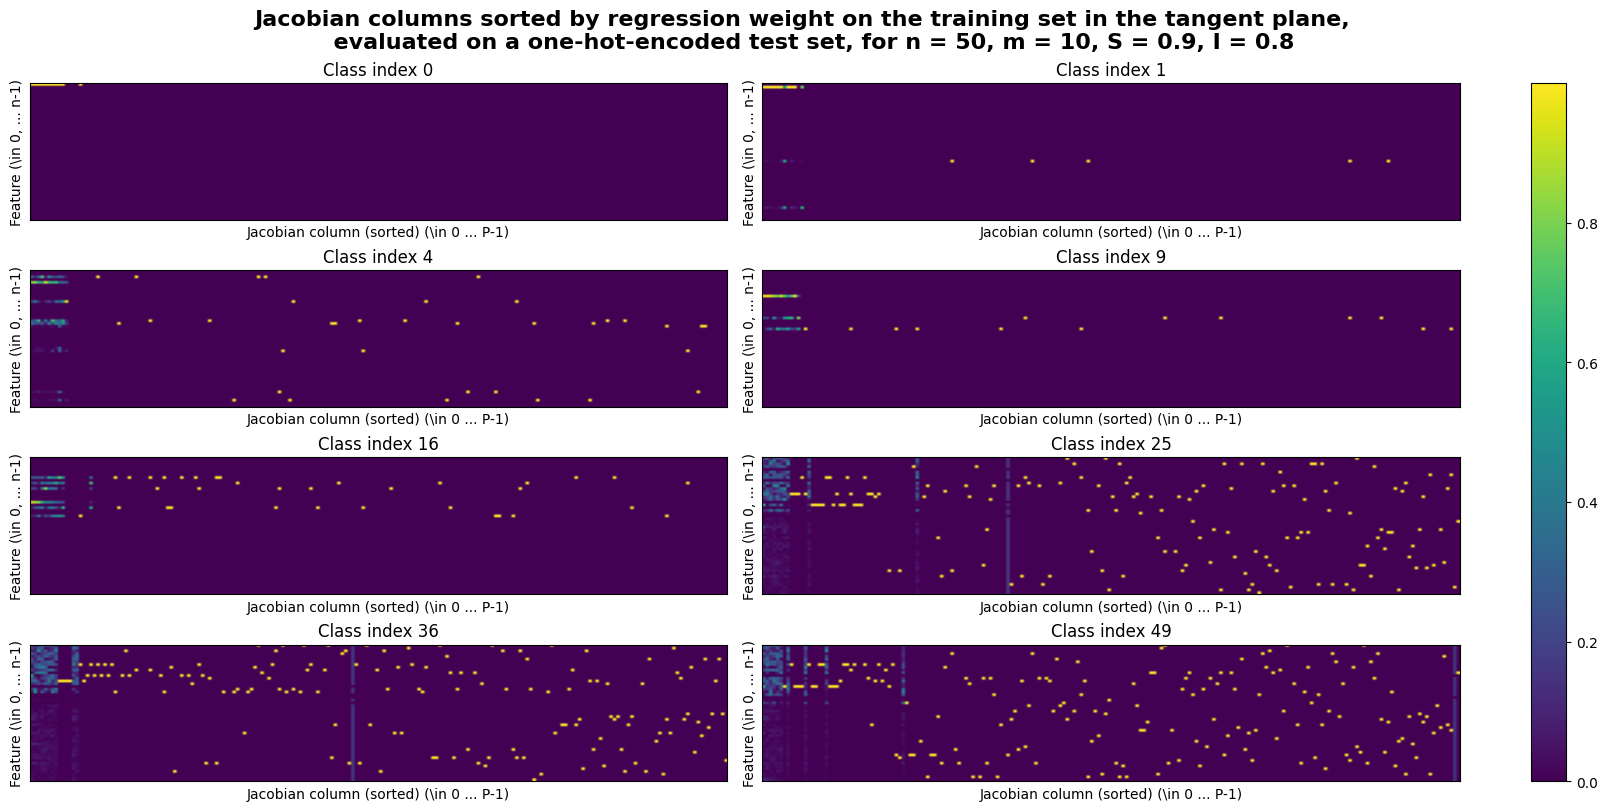

In [ ]:
heatmap(model2, dataset2, test_set_2, [0,1,4,9,16,25,36,49],
 titles = ["Class index 0","Class index 1","Class index 4","Class index 9","Class index 16","Class index 25","Class index 36","Class index 49"],
        suptitle = "Jacobian columns sorted by regression weight on the training set in the tangent plane, \n  evaluated on a one-hot-encoded test set, for n = 50, m = 10, S = 0.9, I = 0.8" , k=200)

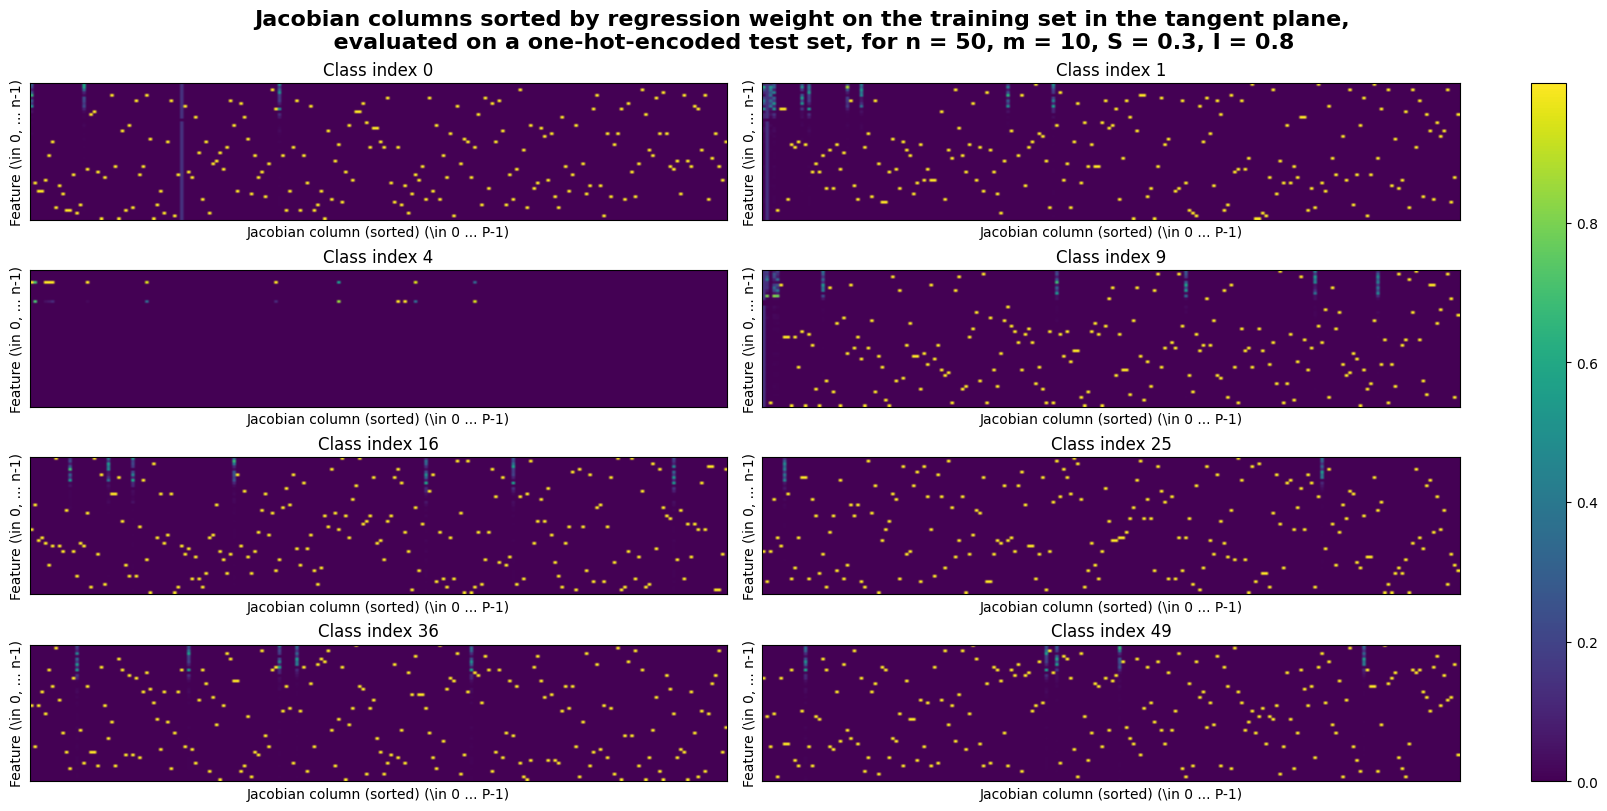

In [ ]:
heatmap(model2m, dataset2m, test_set_2m, [0,1,4,9,16,25,36,49],
 titles = ["Class index 0","Class index 1","Class index 4","Class index 9","Class index 16","Class index 25","Class index 36","Class index 49"],
        suptitle = "Jacobian columns sorted by regression weight on the training set in the tangent plane, \n  evaluated on a one-hot-encoded test set, for n = 50, m = 10, S = 0.3, I = 0.8" , k=200)

# 6. Naive dictionary learning

In [ ]:
# Model 2

batch_size: int = 500
n_features: int = 50
n_hidden: int = 10
sparsity: float = 0.9
importance: float = 0.8

epochs = 5000

dataset2 = generate_batch_with_norm(batch_size, n_features, sparsity).to(device)
model2 = ReluModel(n_features, n_hidden).to(device)
optimizer = t.optim.Adam(model2.parameters(), lr = lr)

for step in tqdm(range(epochs)):
  train_loss = train_tms_fixed(model2, dataset2, optimizer, importance)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

test_set_2 = t.diag(t.ones(dataset2.shape[1])).to(device)

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 0: Train loss 0.0015
Epoch 1000: Train loss 0.0001
Epoch 2000: Train loss 0.0000
Epoch 3000: Train loss 0.0000
Epoch 4000: Train loss 0.0000


In [ ]:
jac = full_jacobian(model2, dataset2)     # Shape (N, C, P)

N,C,P = jac.shape

# Importance-rescale
imp = t.tensor(importance, device = jac.device)**t.arange(C, device = jac.device).sqrt()
jac_rescaled = t.einsum("Ncp,c->Ncp", jac, imp)

# Flatten
jac = jac.reshape(N*C, P)
jac_rescaled = jac_rescaled.reshape(N*C, P)

In [ ]:
k = 50

# 1. Exact NTK eigenbasis reproduction  ------------------------------
A_ntk, S_ntk = learn_dictionary_torch(
        jac_rescaled, k,
        lam_l1 = 0.0,
        lam_ortho    = 1e3,     # big ⇒ AᵀA ≈ I
        n_steps      = 500,
)

In [ ]:
# 2. Plain sparse dictionary baseline  -------------------------------
A_sparse, S_sparse = learn_dictionary_torch(
        jac_rescaled, k,
        lam_l1 = 0.05,    # sweep 0.02–0.2
        lam_ortho    = 0.0,     # no orthogonality
        n_steps      = 1000,
)

In [ ]:
z_flat = t.zeros((N*C, C), device=device)
for j in range(C):
  z_flat[j::C,j] = dataset2[:,j]

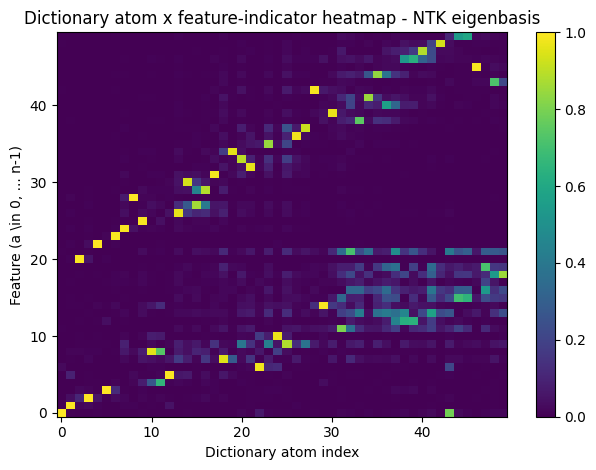

In [ ]:
heatmap = (z_flat.T.detach().cpu().numpy() @ jac.detach().cpu().numpy() @ A_ntk.cpu().numpy())
heatmap = np.abs(heatmap) / (1e-10 + np.linalg.norm(heatmap, axis=0))

fig, ax = plt.subplots()
im = ax.imshow(heatmap, aspect="auto", cmap="viridis", vmin= 0, vmax = 1, origin="lower")
# optional extras -----------------------------------------------------------
ax.set_title("Dictionary atom x feature-indicator heatmap - NTK eigenbasis")
ax.set_xlabel("Dictionary atom index")
ax.set_ylabel("Feature (a \in 0, ... n-1)")
plt.colorbar(im, ax=ax)                   # show a color scale legend
# --------------------------------------------------------------------------

plt.tight_layout()                        # neat spacing
plt.show()

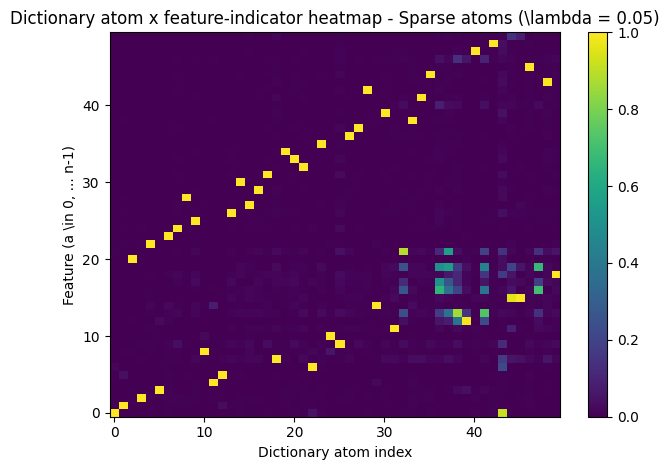

In [ ]:
heatmap = (z_flat.T.detach().cpu().numpy() @ jac.detach().cpu().numpy() @ A_sparse.cpu().numpy())
heatmap = np.abs(heatmap) / (1e-10 + np.linalg.norm(heatmap, axis=0))

fig, ax = plt.subplots()
im = ax.imshow(heatmap, aspect="auto", cmap="viridis", vmin= 0, vmax = 1, origin="lower")
# optional extras -----------------------------------------------------------
ax.set_title("Dictionary atom x feature-indicator heatmap - Sparse atoms (\lambda = 0.05)")
ax.set_xlabel("Dictionary atom index")
ax.set_ylabel("Feature (a \in 0, ... n-1)")
plt.colorbar(im, ax=ax)                   # show a color scale legend
# --------------------------------------------------------------------------

plt.tight_layout()                        # neat spacing
plt.show()

In [ ]:
A_sup, S_sup, head = learn_dictionary_supervised(
        jac_rescaled.to(device), z_flat.to(device),
        k = 50,
        lam_l1   = 0.05,     # sweep
        lam_ortho= 0.0,
        lam_sup  = 10    # sweep 0.1 – 10
)


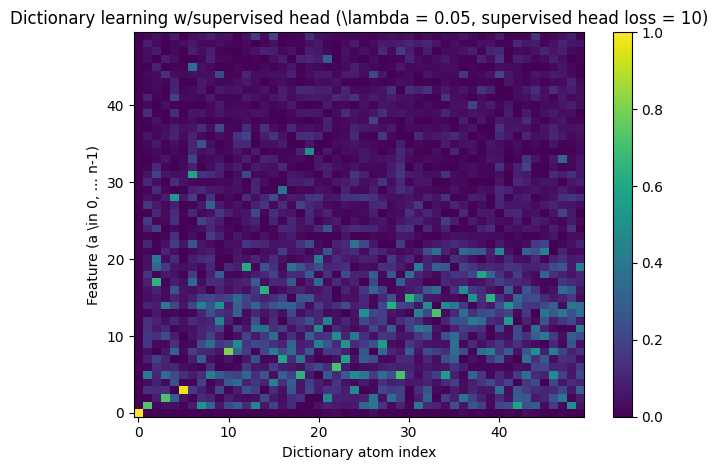

In [ ]:
heatmap = (z_flat.T.detach().cpu().numpy() @ jac.detach().cpu().numpy() @ A_sup.cpu().numpy())
heatmap = np.abs(heatmap) / (1e-10 + np.linalg.norm(heatmap, axis=0))

fig, ax = plt.subplots()
im = ax.imshow(heatmap, aspect="auto", cmap="viridis", vmin= 0, vmax = 1, origin="lower")
# optional extras -----------------------------------------------------------
ax.set_title("Dictionary learning w/supervised head (\lambda = 0.05, supervised head loss = 10)")
ax.set_xlabel("Dictionary atom index")
ax.set_ylabel("Feature (a \in 0, ... n-1)")
plt.colorbar(im, ax=ax)                   # show a color scale legend
# --------------------------------------------------------------------------

plt.tight_layout()                        # neat spacing
plt.show()

# 7. Cross-entropy loss

For an analog of cross-entropy that works for TMS, we should either let the output layer take negative values or flatten the outputs to be in (0,1) and treat them as probabilities. Here are two ad-hoc ways to do these respectively.

In [ ]:
def importance_weighted_shifted_bce(out, labels, importance, pos_prior=0.1, temperature=1.0):
    """
    out: (batch, n_features) from your current ReluModel (>= 0)
    labels: (batch, n_features)  (can be 0/1 or soft in [0,1])
    importance: (n_features,)
    pos_prior: prior P(feature on) ~ (1 - S). With S=0.9 ⇒ 0.1
    """
    b0 = t.logit(t.tensor(pos_prior, device=out.device))   # ≈ -2.197 for 0.1
    logits = (out + b0) / temperature
    per_elem = F.binary_cross_entropy_with_logits(logits, labels, reduction='none')
    return (per_elem * importance.view(1, -1)).mean()

In [ ]:
def importance_weighted_ce_prob(out, labels, importance):
    # Two reasonable squashes; pick one:
    p = 1 - t.exp(-out)              # “exponential CDF” squash
    # p = out / (1 + out)            # Michaelis–Menten / logistic with logit=log(out)

    p = p.clamp(1e-6, 1-1e-6)        # numerical safety
    per_elem = F.binary_cross_entropy(p, labels, reduction='none')
    return (per_elem * importance.view(1, -1)).mean()

In [ ]:
# Models that go in the plots

batch_size: int = 500
n_features: int = 50
n_hidden: int = 10
sparsity: float = 0.9
importance: float = 0.8

epochs = 5000

dataset_10_09 = generate_batch_with_norm(batch_size, n_features, sparsity).to(device)
model_10_09 = ReluModel(n_features, n_hidden).to(device)
optimizer = t.optim.Adam(model_10_09.parameters(), lr = lr)

for step in tqdm(range(epochs)):
  train_loss = train_tms_fixed(model_10_09, dataset_10_09, optimizer, importance, loss_fn = importance_weighted_ce_prob)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

test_set_10_09 = t.diag(t.ones(dataset_10_09.shape[1])).to(device)

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 0: Train loss 0.0160
Epoch 1000: Train loss 0.0072
Epoch 2000: Train loss 0.0067
Epoch 3000: Train loss 0.0065
Epoch 4000: Train loss 0.0064


In [ ]:
# Models that go in the plots

batch_size: int = 500
n_features: int = 50
n_hidden: int = 10
sparsity: float = 0.3
importance: float = 0.8

epochs = 5000

dataset_10_03 = generate_batch_with_norm(batch_size, n_features, sparsity).to(device)
model_10_03 = ReluModel(n_features, n_hidden).to(device)
optimizer = t.optim.Adam(model_10_03.parameters(), lr = lr)

for step in tqdm(range(epochs)):
  train_loss = train_tms_fixed(model_10_03, dataset_10_03, optimizer, importance, loss_fn = importance_weighted_ce_prob)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

test_set_10_03 = t.diag(t.ones(dataset_10_03.shape[1])).to(device)

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 0: Train loss 0.0767
Epoch 1000: Train loss 0.0315
Epoch 2000: Train loss 0.0294
Epoch 3000: Train loss 0.0285
Epoch 4000: Train loss 0.0279


In [ ]:
# Models that go in the plots

batch_size: int = 500
n_features: int = 50
n_hidden: int = 40
sparsity: float = 0.9
importance: float = 0.8

epochs = 5000

dataset_40_09 = generate_batch_with_norm(batch_size, n_features, sparsity).to(device)
model_40_09 = ReluModel(n_features, n_hidden).to(device)
optimizer = t.optim.Adam(model_40_09.parameters(), lr = lr)

for step in tqdm(range(epochs)):
  train_loss = train_tms_fixed(model_40_09, dataset_40_09, optimizer, importance, loss_fn = importance_weighted_ce_prob)
  if (step % 1000 == 0):
    print(f"Epoch {step}: Train loss {train_loss:.4f}")

test_set_40_09 = t.diag(t.ones(dataset_40_09.shape[1])).to(device)

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 0: Train loss 0.0125
Epoch 1000: Train loss 0.0058
Epoch 2000: Train loss 0.0057
Epoch 3000: Train loss 0.0057
Epoch 4000: Train loss 0.0057


In [ ]:
A = make_flattened_heatmap(model_10_09, dataset_10_09, k = 80, normalize = True)
B = make_flattened_heatmap(model_10_03, dataset_10_03, k = 80, normalize = True)
C = make_flattened_heatmap(model_40_09, dataset_40_09, k = 80, normalize = True)

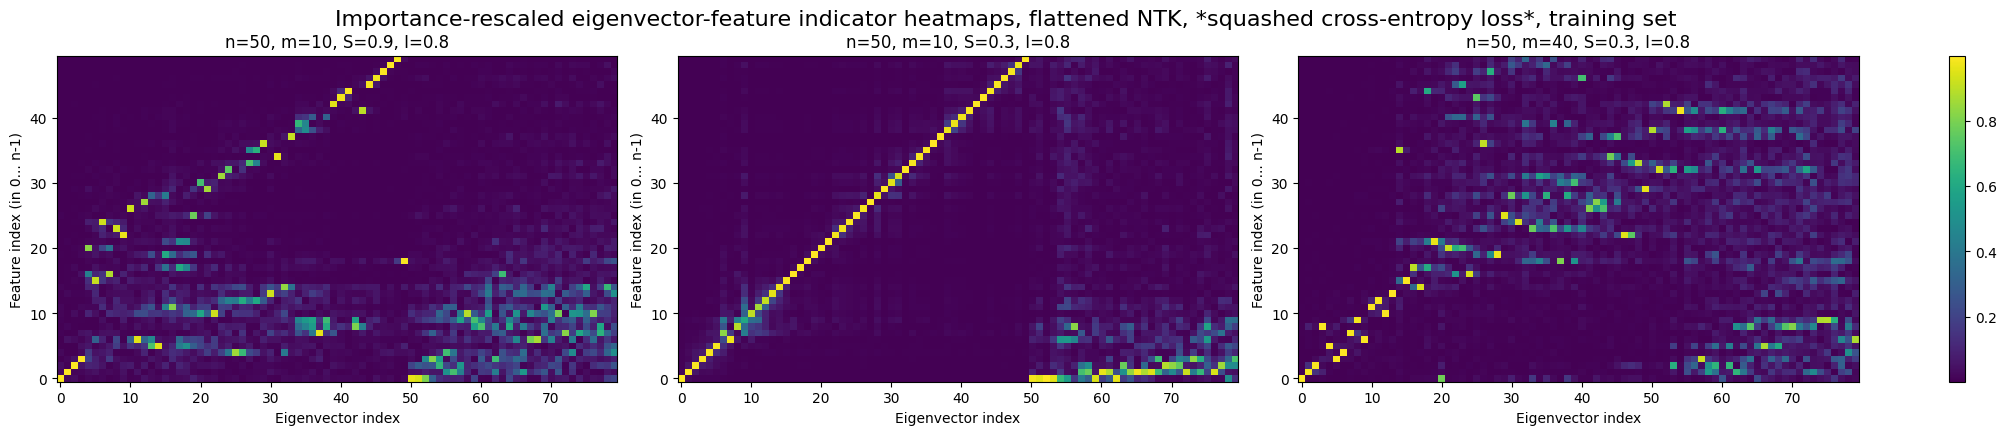

In [ ]:
matrices = [A, B, C]
titles   = ["n=50, m=10, S=0.9, I=0.8", "n=50, m=10, S=0.3, I=0.8", "n=50, m=40, S=0.3, I=0.8"]
overall  = "Importance-rescaled eigenvector-feature indicator heatmaps, flattened NTK, *squashed cross-entropy loss*, training set"

fig, axes = plt.subplots(1, 3, figsize=(20, 4), constrained_layout=True)

for ax, mat, title in zip(axes, matrices, titles):
    im = ax.imshow(mat, aspect="auto", origin="lower")   # default colormap
    ax.set_title(title)
    ax.set_xlabel("Eigenvector index")
    ax.set_ylabel("Feature index (in 0... n-1)")

fig.colorbar(im, ax=axes.ravel().tolist(), location="right")  # default colormap
fig.suptitle(overall, fontsize=16, y=1.05)  # overall title
plt.show()

In [ ]:
A = make_flattened_heatmap(model_10_09, test_set_10_09, k = 80, normalize = True)
B = make_flattened_heatmap(model_10_03, test_set_10_03, k = 80, normalize = True)
C = make_flattened_heatmap(model_40_09, test_set_40_09, k = 80, normalize = True)

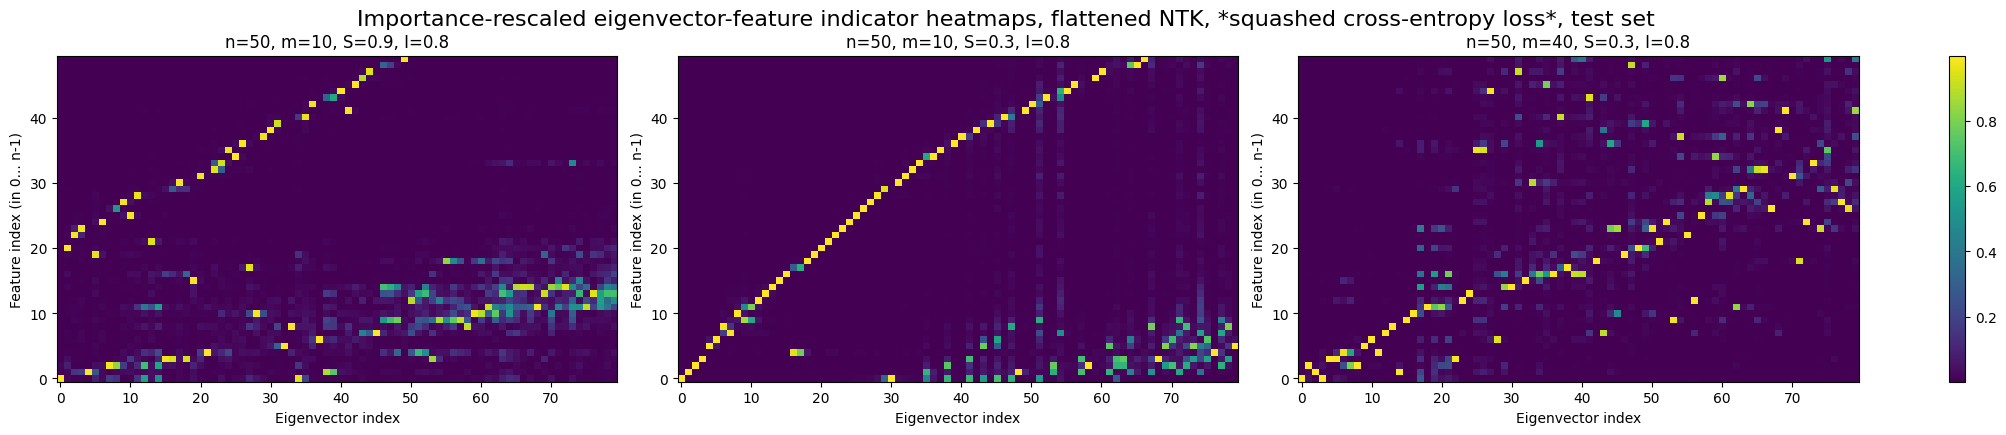

In [ ]:
matrices = [A, B, C]
titles   = ["n=50, m=10, S=0.9, I=0.8", "n=50, m=10, S=0.3, I=0.8", "n=50, m=40, S=0.3, I=0.8"]
overall  = "Importance-rescaled eigenvector-feature indicator heatmaps, flattened NTK, *squashed cross-entropy loss*, test set"

fig, axes = plt.subplots(1, 3, figsize=(20, 4), constrained_layout=True)

for ax, mat, title in zip(axes, matrices, titles):
    im = ax.imshow(mat, aspect="auto", origin="lower")   # default colormap
    ax.set_title(title)
    ax.set_xlabel("Eigenvector index")
    ax.set_ylabel("Feature index (in 0... n-1)")

fig.colorbar(im, ax=axes.ravel().tolist(), location="right")  # default colormap
fig.suptitle(overall, fontsize=16, y=1.05)  # overall title
plt.show()

In [ ]:
A = make_flattened_heatmap(model_10_09, test_set_10_09, k = 80, normalize = False)
B = make_flattened_heatmap(model_10_03, test_set_10_03, k = 80, normalize = False)
C = make_flattened_heatmap(model_40_09, test_set_40_09, k = 80, normalize = False)

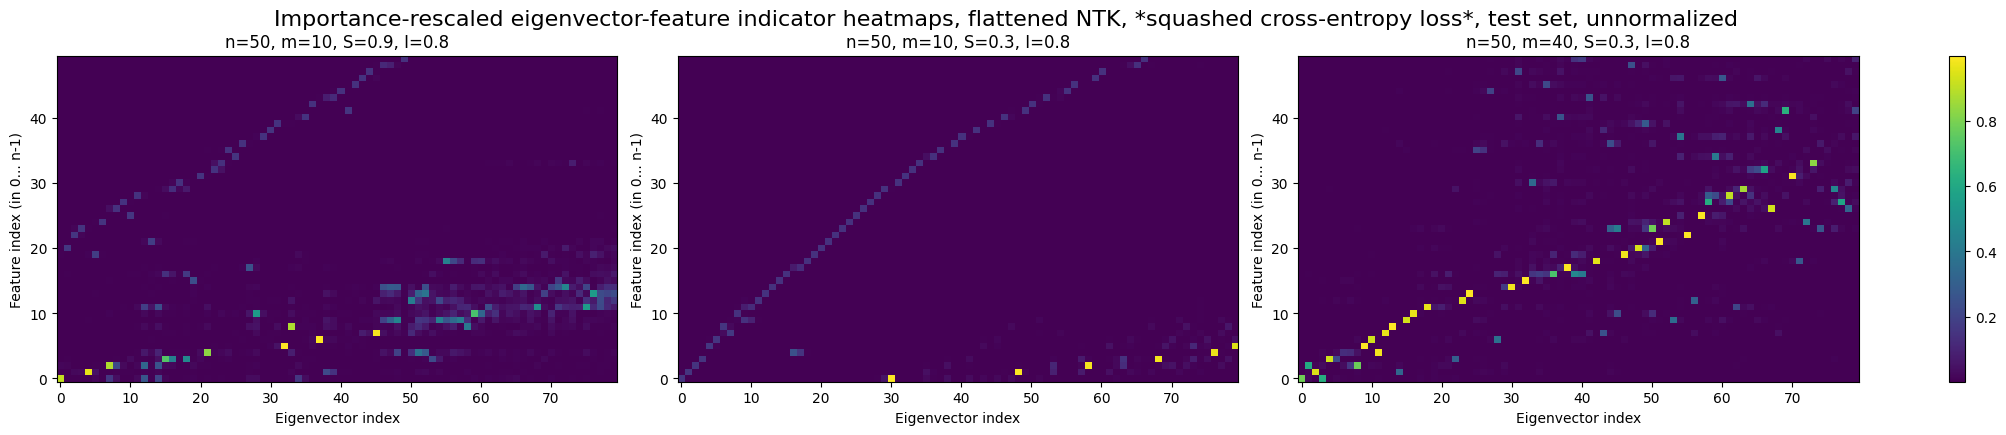

In [ ]:
matrices = [A, B, C]
titles   = ["n=50, m=10, S=0.9, I=0.8", "n=50, m=10, S=0.3, I=0.8", "n=50, m=40, S=0.3, I=0.8"]
overall  = "Importance-rescaled eigenvector-feature indicator heatmaps, flattened NTK, *squashed cross-entropy loss*, test set, unnormalized"

fig, axes = plt.subplots(1, 3, figsize=(20, 4), constrained_layout=True)

for ax, mat, title in zip(axes, matrices, titles):
    im = ax.imshow(mat, aspect="auto", origin="lower")   # default colormap
    ax.set_title(title)
    ax.set_xlabel("Eigenvector index")
    ax.set_ylabel("Feature index (in 0... n-1)")

fig.colorbar(im, ax=axes.ravel().tolist(), location="right")  # default colormap
fig.suptitle(overall, fontsize=16, y=1.05)  # overall title
plt.show()